(Bayesian Missing Data Imputation)=
# Bayesian Missing Data Imputation

:::{post} January, 2023
:tags: missing data, multiple imputation, 
:category: advanced
:author: Nathaniel Forde
:::

## Introduction

In [1]:
import random

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.optimize

from matplotlib.lines import Line2D
from scipy.stats import multivariate_normal

## Bayesian Imputation and Degrees of Missing-ness

The analysis of data with missing values is a gateway into the study of causal inference. 

One of the key features of any analysis plagued by missing data is the assumption which governs the nature of the missing-ness i.e. what is the reason our data gaps? Can we ignore them? In this notebook we'll see an example of how to handle missing data using maximum likelihood estimation and bayesian imputation techniques. This will open up questions about the assumptions governing inference in the presence of missing data, and inference in counterfactual cases.  


In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Missing Data Taxonomy

Rubin's famous taxonomy breaks out the question into a choice of three fundamental options:

 - Missing Completely at Random (MCAR)
 - Missing at Random (MAR)
 - Missing Not at Random (MNAR)

Each of these paradigms can be reduced to explicit definition in terms of the conditional probability regarding the **pattern of missing data**. The first pattern is the least concerning. The (MCAR) assumption states that the data are missing in a manner that is unrelated to both the observed and unobserved parts of the realised data. It is missing due to the haphazard circumstance of the world $\phi$.

$$  P(M =1 | Y_{obs}, Y_{miss}, \phi) = P(M =1 | \phi) $$

whereas the second pattern (MAR) allows that the reasons for missingness can be function of the observed data and circumstances of the world. Some times this is called a case of *ignorable* missingness because estimation can proceed in good faith on the basis of the observed data. There may be a loss of precision, but the inference should be sound.  

$$  P(M =1 | Y_{obs}, Y_{miss}, \phi) = P(M =1 | Y_{obs}, \phi) $$ 

The most nefarious sort of missing data is when the missingness is a function of something outside the observed data, and the equation cannot be reduced further. Efforts at imputation and estimation more generally may become more difficuly in this final case because of the risk of confounding. This is a case of *non-ignorable* missingness. 

$$  P(M =1 | Y_{obs}, Y_{miss}, \phi) $$

These assumptions are made before any analysis begins. They are inherently unverifiable. Your analysis will stand or fall depending on how plausible each assumption is in the context you seek to apply them. 

### Employee Satisfaction Surveys

We'll follow the presentation of Craig Enders' *Applied Missing Data Analysis* {cite:t}`enders2022` and work with employee satisifaction data set. The data set comprises of a few composite measures reporting employee working conditions and satisfactions. Of particular note are empowerment (`empower`), work satisfaction (`worksat`) and two composite survey scores recording the employees leadership climate (`climate`), and the relationship quality with their supervisor `lmx`. 

As is common in employee surveys, many values are missing. This notebook will show how to use a variety of techniques to impute or infer the profile of the missing values. 

| empower 	| climate 	| lmx 	| empower_obs 	| climate_obs 	| lmx_obs 	| empower_pattern 	| climate_pattern 	| lmx_pattern 	|
|---	|---	|---	|---	|---	|---	|---	|---	|---	|
| 5 	| 6 	| 7 	| 5 	| NA 	| 7 	| True 	| False 	| True 	|
| 7 	| 4 	| 5 	| NA 	| 4 	| 5 	| False 	| True 	| True 	|

The key question is what assumptions governs our patterns of missing data.


In [3]:
df_employee = pd.read_csv("../data/employee.csv")
df_employee

employee  team  turnover  male  empower   lmx  worksat  climate  cohesion
0           1     1       0.0     1     32.0  11.0      3.0     18.0       3.5
1           2     1       1.0     1      NaN  13.0      4.0     18.0       3.5
2           3     1       1.0     1     30.0   9.0      4.0     18.0       3.5
3           4     1       1.0     1     29.0   8.0      3.0     18.0       3.5
4           5     1       1.0     0     26.0   7.0      4.0     18.0       3.5
..        ...   ...       ...   ...      ...   ...      ...      ...       ...
625       626   105       1.0     0     28.0   5.0      4.0     21.0       5.0
626       627   105       1.0     0     17.0   5.0      3.0     21.0       5.0
627       628   105       1.0     1     28.0  10.0      4.0     21.0       5.0
628       629   105       0.0     0      NaN   9.0      4.0     21.0       5.0
629       630   105       1.0     1     32.0   5.0      3.0     21.0       5.0

[630 rows x 9 columns]

In [4]:
df_employee[["worksat", "empower", "lmx"]].isna().sum() / len(df_employee)

worksat    0.047619
empower    0.161905
lmx        0.041270
dtype: float64

Text(0.5, 1.0, 'Employee Satisfaction Survey Results')

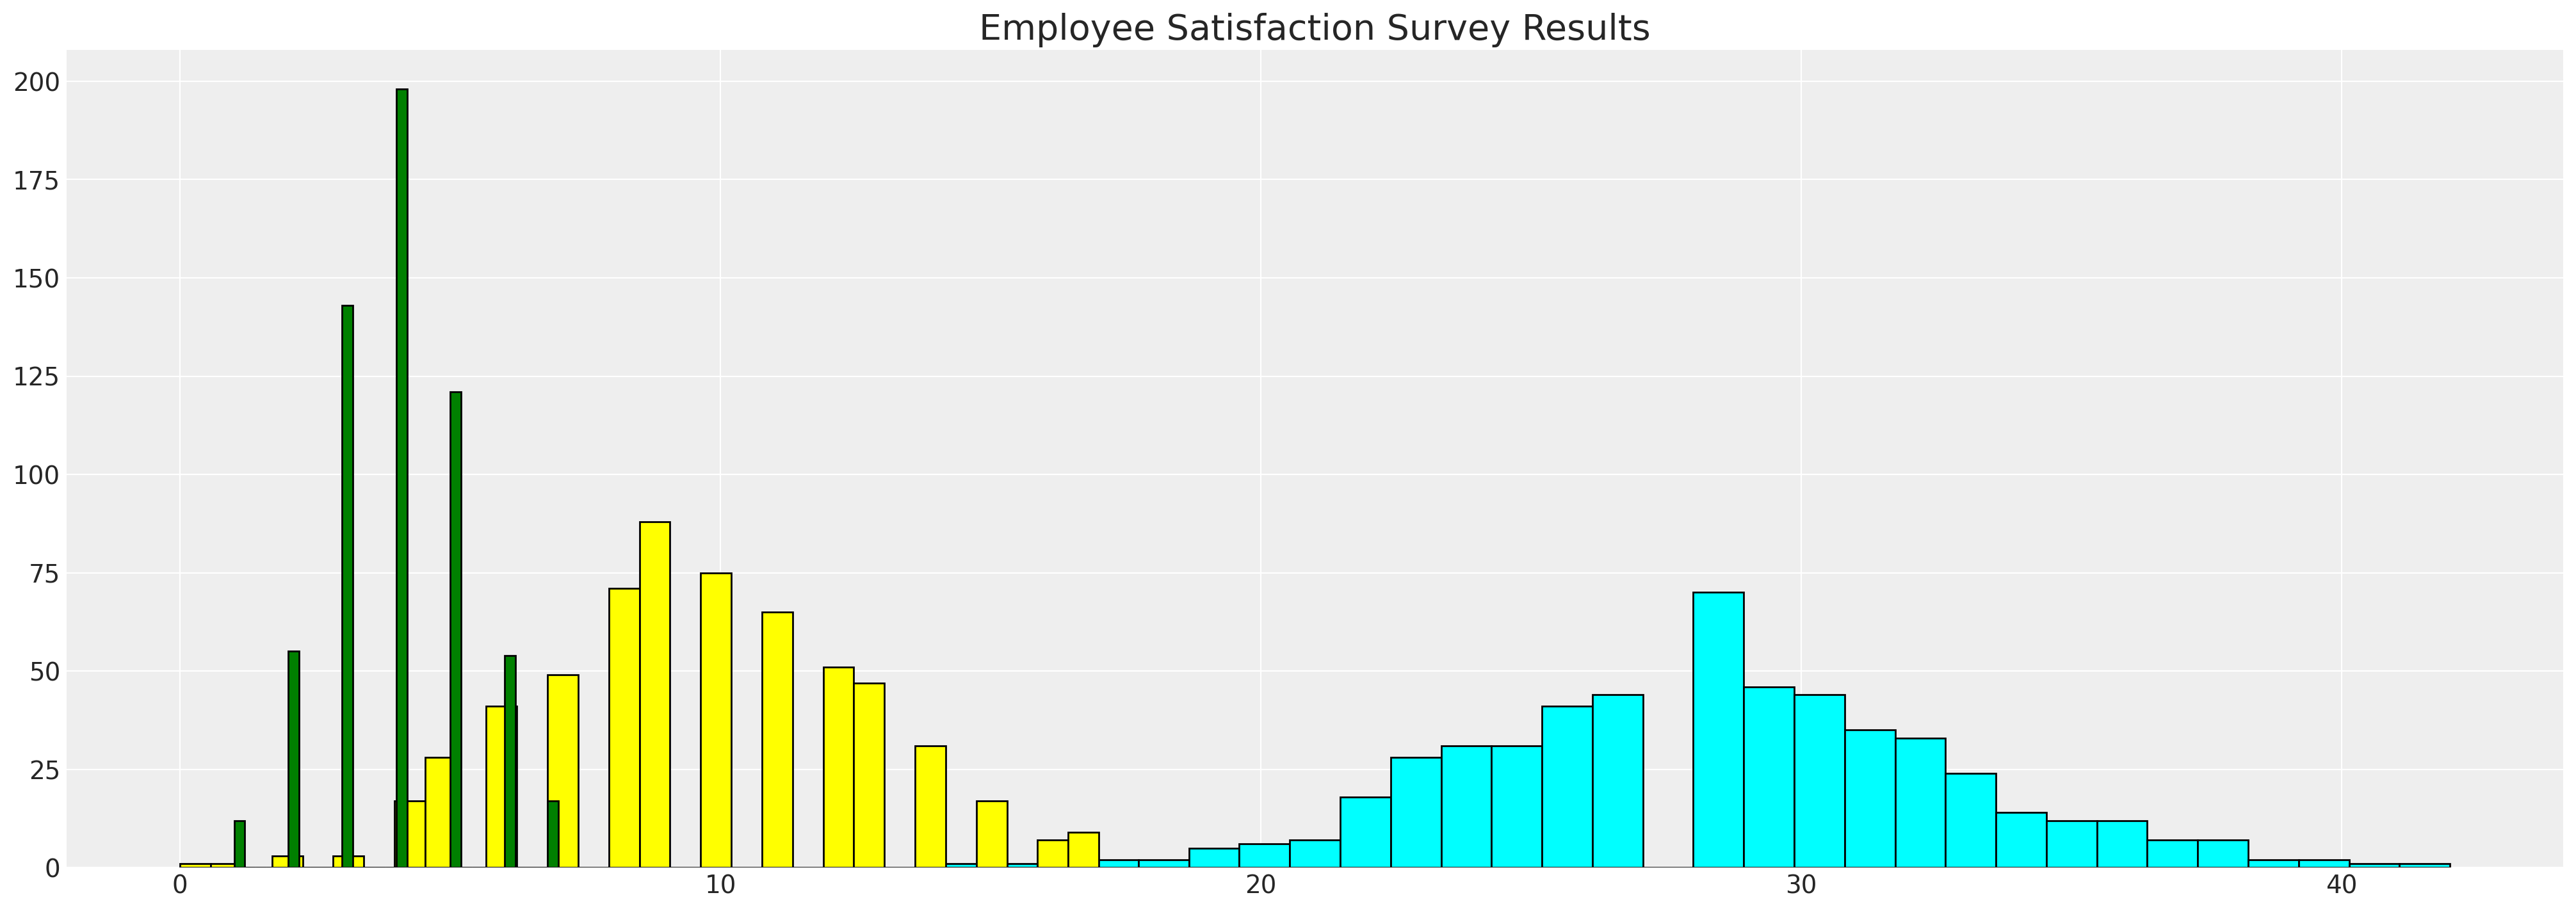

In [5]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(df_employee["empower"], bins=30, ec="black", color="cyan", label="Empowerment")
ax.hist(df_employee["lmx"], bins=30, ec="black", color="yellow", label="LMX")
ax.hist(df_employee["worksat"], bins=30, ec="black", color="green", label="Work Satisfaction")
ax.set_title("Employee Satisfaction Survey Results", fontsize=20)

## FIML: Full Information Maximum Likelihood 

This method of handling missing data is **not** an imputation method. It uses maximum likelihood estimation to estimate the parameters of the multivariate normal distribution that could be best said to generate our observed data. It's a little trickier than straight forward MLE approaches in that it respects the fact that we have missing data in our original data set. 

The procedure works by partitioning the data into their patterns of "missing-ness" and treating each partition as contributing to the ultimate log-likelihood term that we want to maximise. We combine their contributions to estimate a fit for the multivariate normal distribution.  

In [6]:
data = df_employee[["worksat", "empower", "lmx"]]


def split_data_by_missing_pattern(data):
    ## We want to extract our the pattern of missing-ness in our dataset
    ## and save each sub-set of our data in a structure that can be used to feed into a log-likelihood function
    grouped_patterns = []
    patterns = data.notnull().drop_duplicates().values
    # A pattern is whether the values in each column e.g. [True, True, True] or [True, True, False]
    observed = data.notnull()
    for p in range(len(patterns)):
        temp = observed[
            (observed["worksat"] == patterns[p][0])
            & (observed["empower"] == patterns[p][1])
            & (observed["lmx"] == patterns[p][2])
        ]
        grouped_patterns.append([patterns[p], temp.index, data.iloc[temp.index].dropna(axis=1)])

    return grouped_patterns


def reconstitute_params(params_vector, n_vars):
    ## Convenience numpy function to construct mirrored COV matrix
    ## From flattened params_vector
    mus = params_vector[0:n_vars]
    cov_flat = params_vector[n_vars:]
    indices = np.tril_indices(n_vars)
    cov = np.empty((n_vars, n_vars))
    for i, j, c in zip(indices[0], indices[1], cov_flat):
        cov[i, j] = c
        cov[j, i] = c
    cov = cov + 1e-25
    return mus, cov


def optimise_ll(flat_params, n_vars, grouped_patterns):
    mus, cov = reconstitute_params(flat_params, n_vars)
    ## Check if COV is positive definite
    if (np.linalg.eigvalsh(cov) < 0).any():
        return 1e100
    objval = 0.0
    for obs_pattern, _, obs_data in grouped_patterns:
        ## This is the key (tricky) step because we're selecting the variables which pattern
        ## the full information set within each pattern of "missing-ness"
        ## e.g. when the observed pattern is [True, True, False] we want the first two variables
        ## of the mus vector and we want only the covariance relations between the relevant variables from the cov
        ## in the iteration.
        obs_mus = mus[obs_pattern]
        obs_cov = cov[obs_pattern][:, obs_pattern]
        ll = np.sum(multivariate_normal(obs_mus, obs_cov).logpdf(obs_data))
        objval = ll + objval
    return -objval


def estimate(data):
    n_vars = data.shape[1]
    ## Initialise
    mus0 = np.zeros(n_vars)
    cov0 = np.eye(n_vars)
    ## Flatten params for optimiser
    params0 = np.append(mus0, cov0[np.tril_indices(n_vars)])
    ## Process Data
    grouped_patterns = split_data_by_missing_pattern(data)
    ## Run the Optimiser.
    try:
        result = scipy.optimize.minimize(
            optimise_ll, params0, args=(n_vars, grouped_patterns), method="Powell"
        )
    except Exception as e:
        raise e
    mean, cov = reconstitute_params(result.x, n_vars)
    return mean, cov


fiml_mus, fiml_cov = estimate(data)


print("Full information Maximum Likelihood Estimate Mu:")
display(pd.DataFrame(fiml_mus, index=data.columns).T)
print("Full information Maximum Likelihood Estimate COV:")
pd.DataFrame(fiml_cov, columns=data.columns, index=data.columns)

Full information Maximum Likelihood Estimate Mu:


worksat    empower       lmx
0  3.983351  28.595211  9.624485

Full information Maximum Likelihood Estimate COV:


worksat    empower       lmx
worksat  1.568676   1.599817  1.547433
empower  1.599817  19.138522  5.428954
lmx      1.547433   5.428954  8.934030

### Sampling from the Implied Distribution

We can then sample from the implied distribution to estimate other features of interest and test against the observed data.

In [7]:
mle_fit = multivariate_normal(fiml_mus, fiml_cov)
mle_sample = mle_fit.rvs(10000)
mle_sample = pd.DataFrame(mle_sample, columns=["worksat", "empower", "lmx"])
mle_sample

worksat    empower        lmx
0     3.750731  23.650170   6.747339
1     5.911609  31.099173  12.553215
2     0.645569  30.561748   5.013520
3     5.561073  29.986688   7.349989
4     5.565812  26.403014  14.611087
...        ...        ...        ...
9995  1.618000  27.347836   5.938627
9996  4.365286  24.231415   9.510925
9997  4.273089  25.379773   7.818225
9998  4.810181  27.241699   9.171038
9999  1.646202  29.319238   7.554201

[10000 rows x 3 columns]

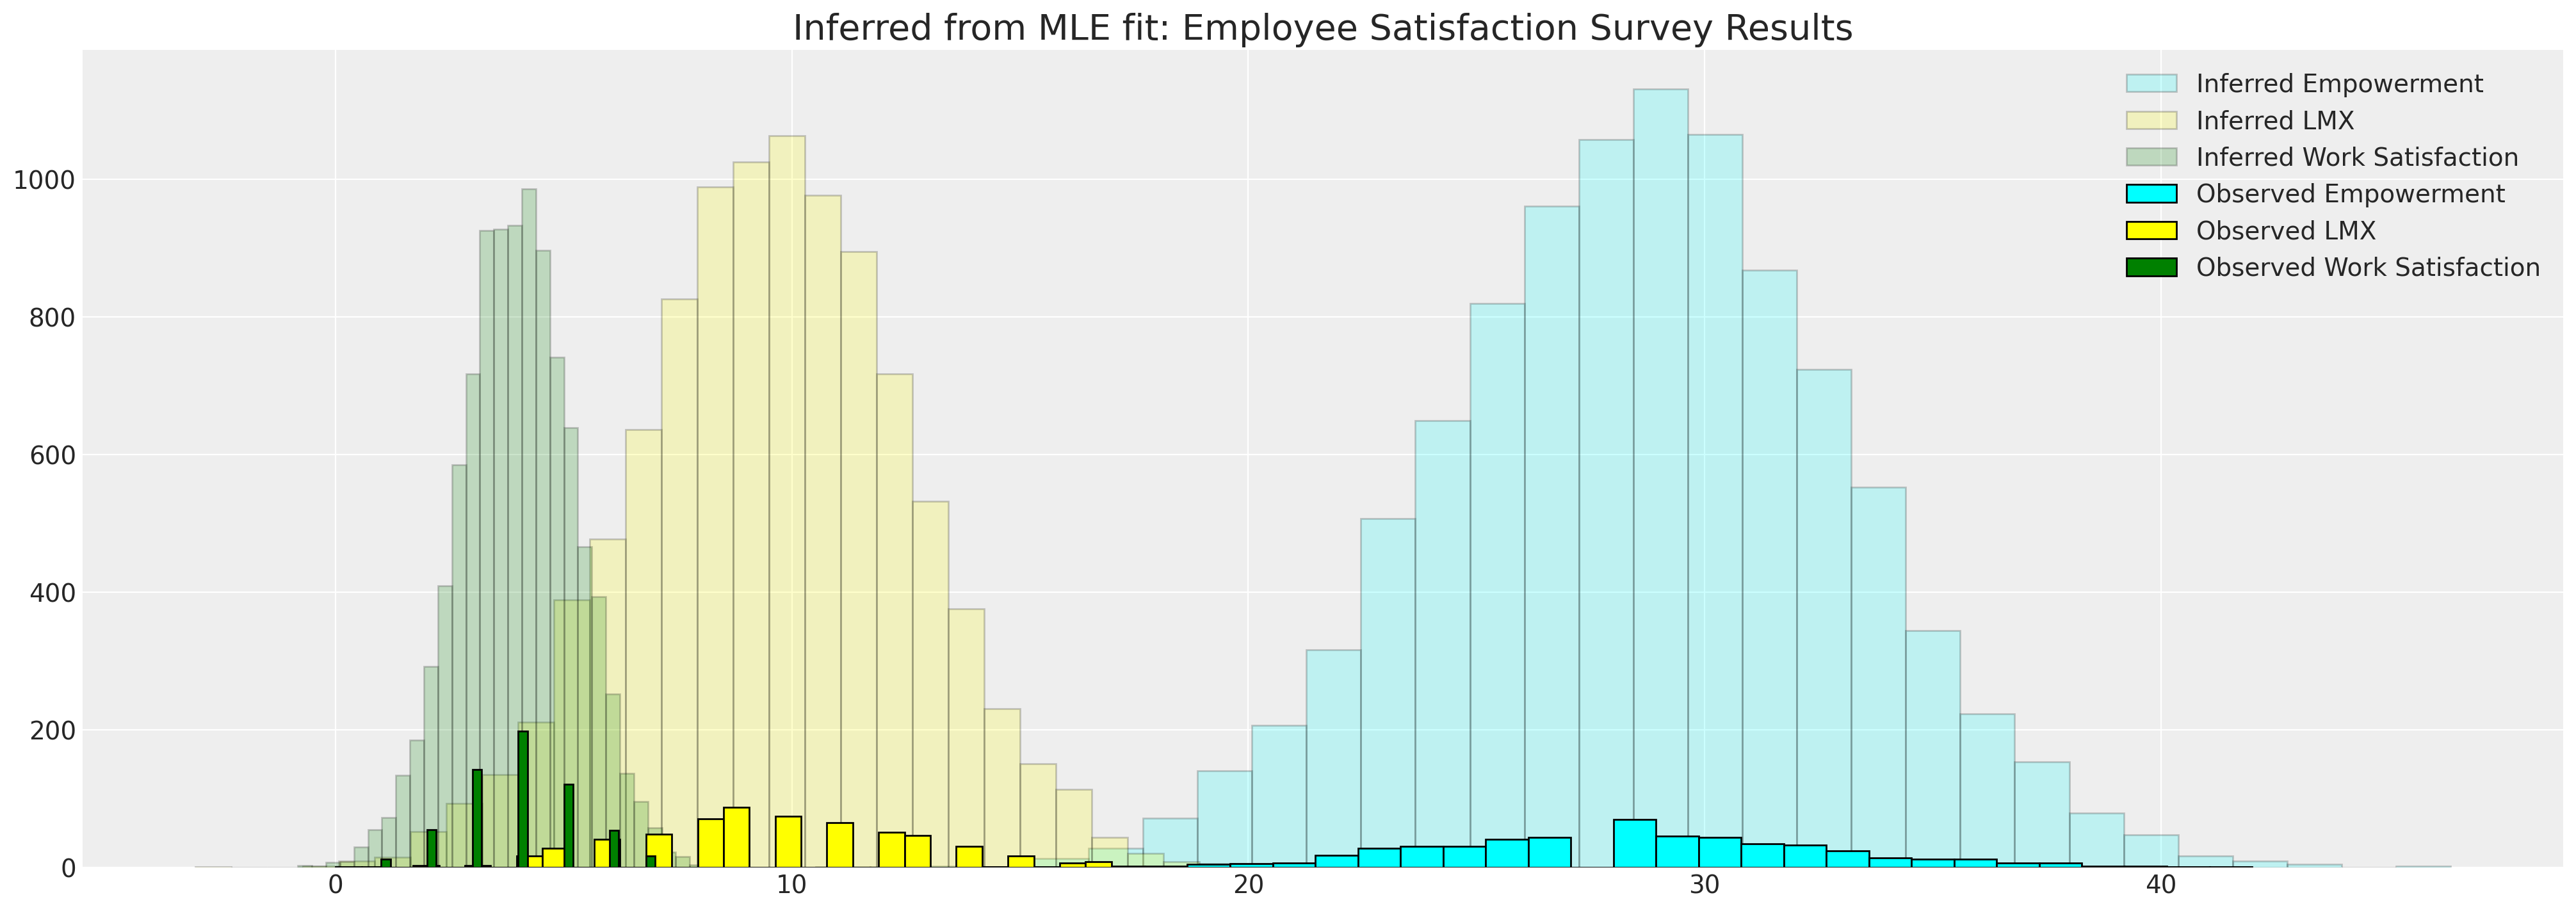

In [8]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.hist(
    mle_sample["empower"],
    bins=30,
    ec="black",
    color="cyan",
    alpha=0.2,
    label="Inferred Empowerment",
)
ax.hist(mle_sample["lmx"], bins=30, ec="black", color="yellow", alpha=0.2, label="Inferred LMX")
ax.hist(
    mle_sample["worksat"],
    bins=30,
    ec="black",
    color="green",
    alpha=0.2,
    label="Inferred Work Satisfaction",
)
ax.hist(data["empower"], bins=30, ec="black", color="cyan", label="Observed Empowerment")
ax.hist(data["lmx"], bins=30, ec="black", color="yellow", label="Observed LMX")
ax.hist(data["worksat"], bins=30, ec="black", color="green", label="Observed Work Satisfaction")
ax.set_title("Inferred from MLE fit: Employee Satisfaction Survey Results", fontsize=20)
ax.legend()

### The Correlation Between the Imputed Metrics Data

In [9]:
pd.DataFrame(mle_sample.corr(), columns=data.columns, index=data.columns)

worksat   empower       lmx
worksat  1.000000  0.297914  0.413354
empower  0.297914  1.000000  0.416615
lmx      0.413354  0.416615  1.000000

### Bootstrapping Sensitivity Analysis

We may also want to validate the estimated parameters against bootstrapped samples under different speficiations of missing-ness. 

In [10]:
data_200 = df_employee[["worksat", "empower", "lmx"]].dropna().sample(200)
data_200.reset_index(inplace=True, drop=True)


sensitivity = {}
n_missing = np.linspace(30, 100, 5)  ## Change or alter the range as desired
bootstrap_iterations = 100  # change to large number running a real analysis in this case
for n in n_missing:
    sensitivity[int(n)] = {}
    sensitivity[int(n)]["mus"] = []
    sensitivity[int(n)]["cov"] = []
    for i in range(bootstrap_iterations):
        temp = data_200.copy()
        for m in range(int(n)):
            i = random.choice(range(200))
            j = random.choice(range(3))
            temp.iloc[i, j] = np.nan
        try:
            fiml_mus, fiml_cov = estimate(temp)
            sensitivity[int(n)]["mus"].append(fiml_mus)
            sensitivity[int(n)]["cov"].append(fiml_cov)
        except Exception as e:
            next

Here we plot the maximum likelihood parameter estimates against various missing data regimes. This approach can be applied for any imputation methodology.

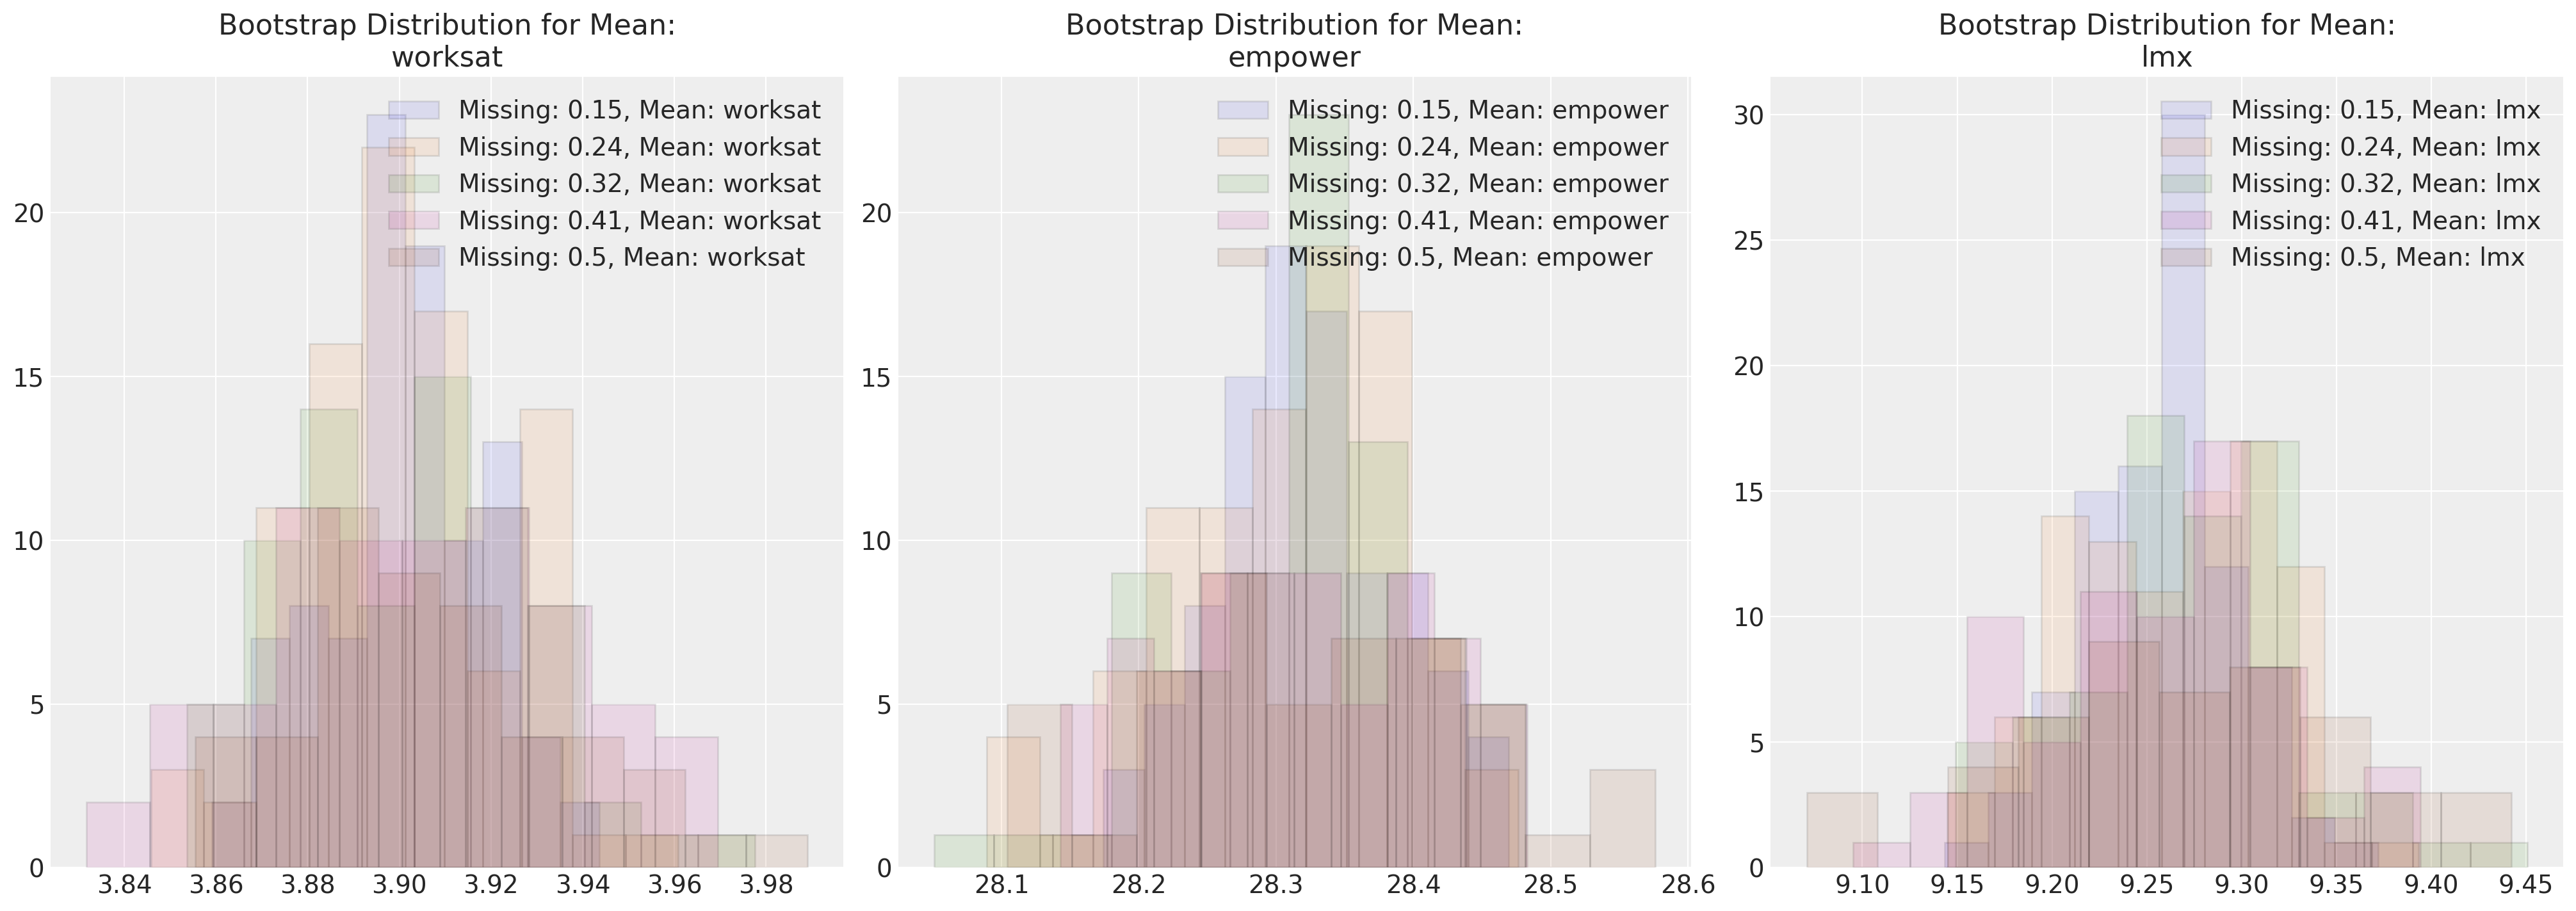

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
for n in sensitivity.keys():
    temp = pd.DataFrame(sensitivity[n]["mus"], columns=["worksat", "empower", "lmx"])
    for col, ax in zip(temp.columns, axs):
        ax.hist(
            temp[col], alpha=0.1, ec="black", label=f"Missing: {np.round(n/200, 2)}, Mean: {col}"
        )
        ax.legend()
        ax.set_title(f"Bootstrap Distribution for Mean:\n{col}")

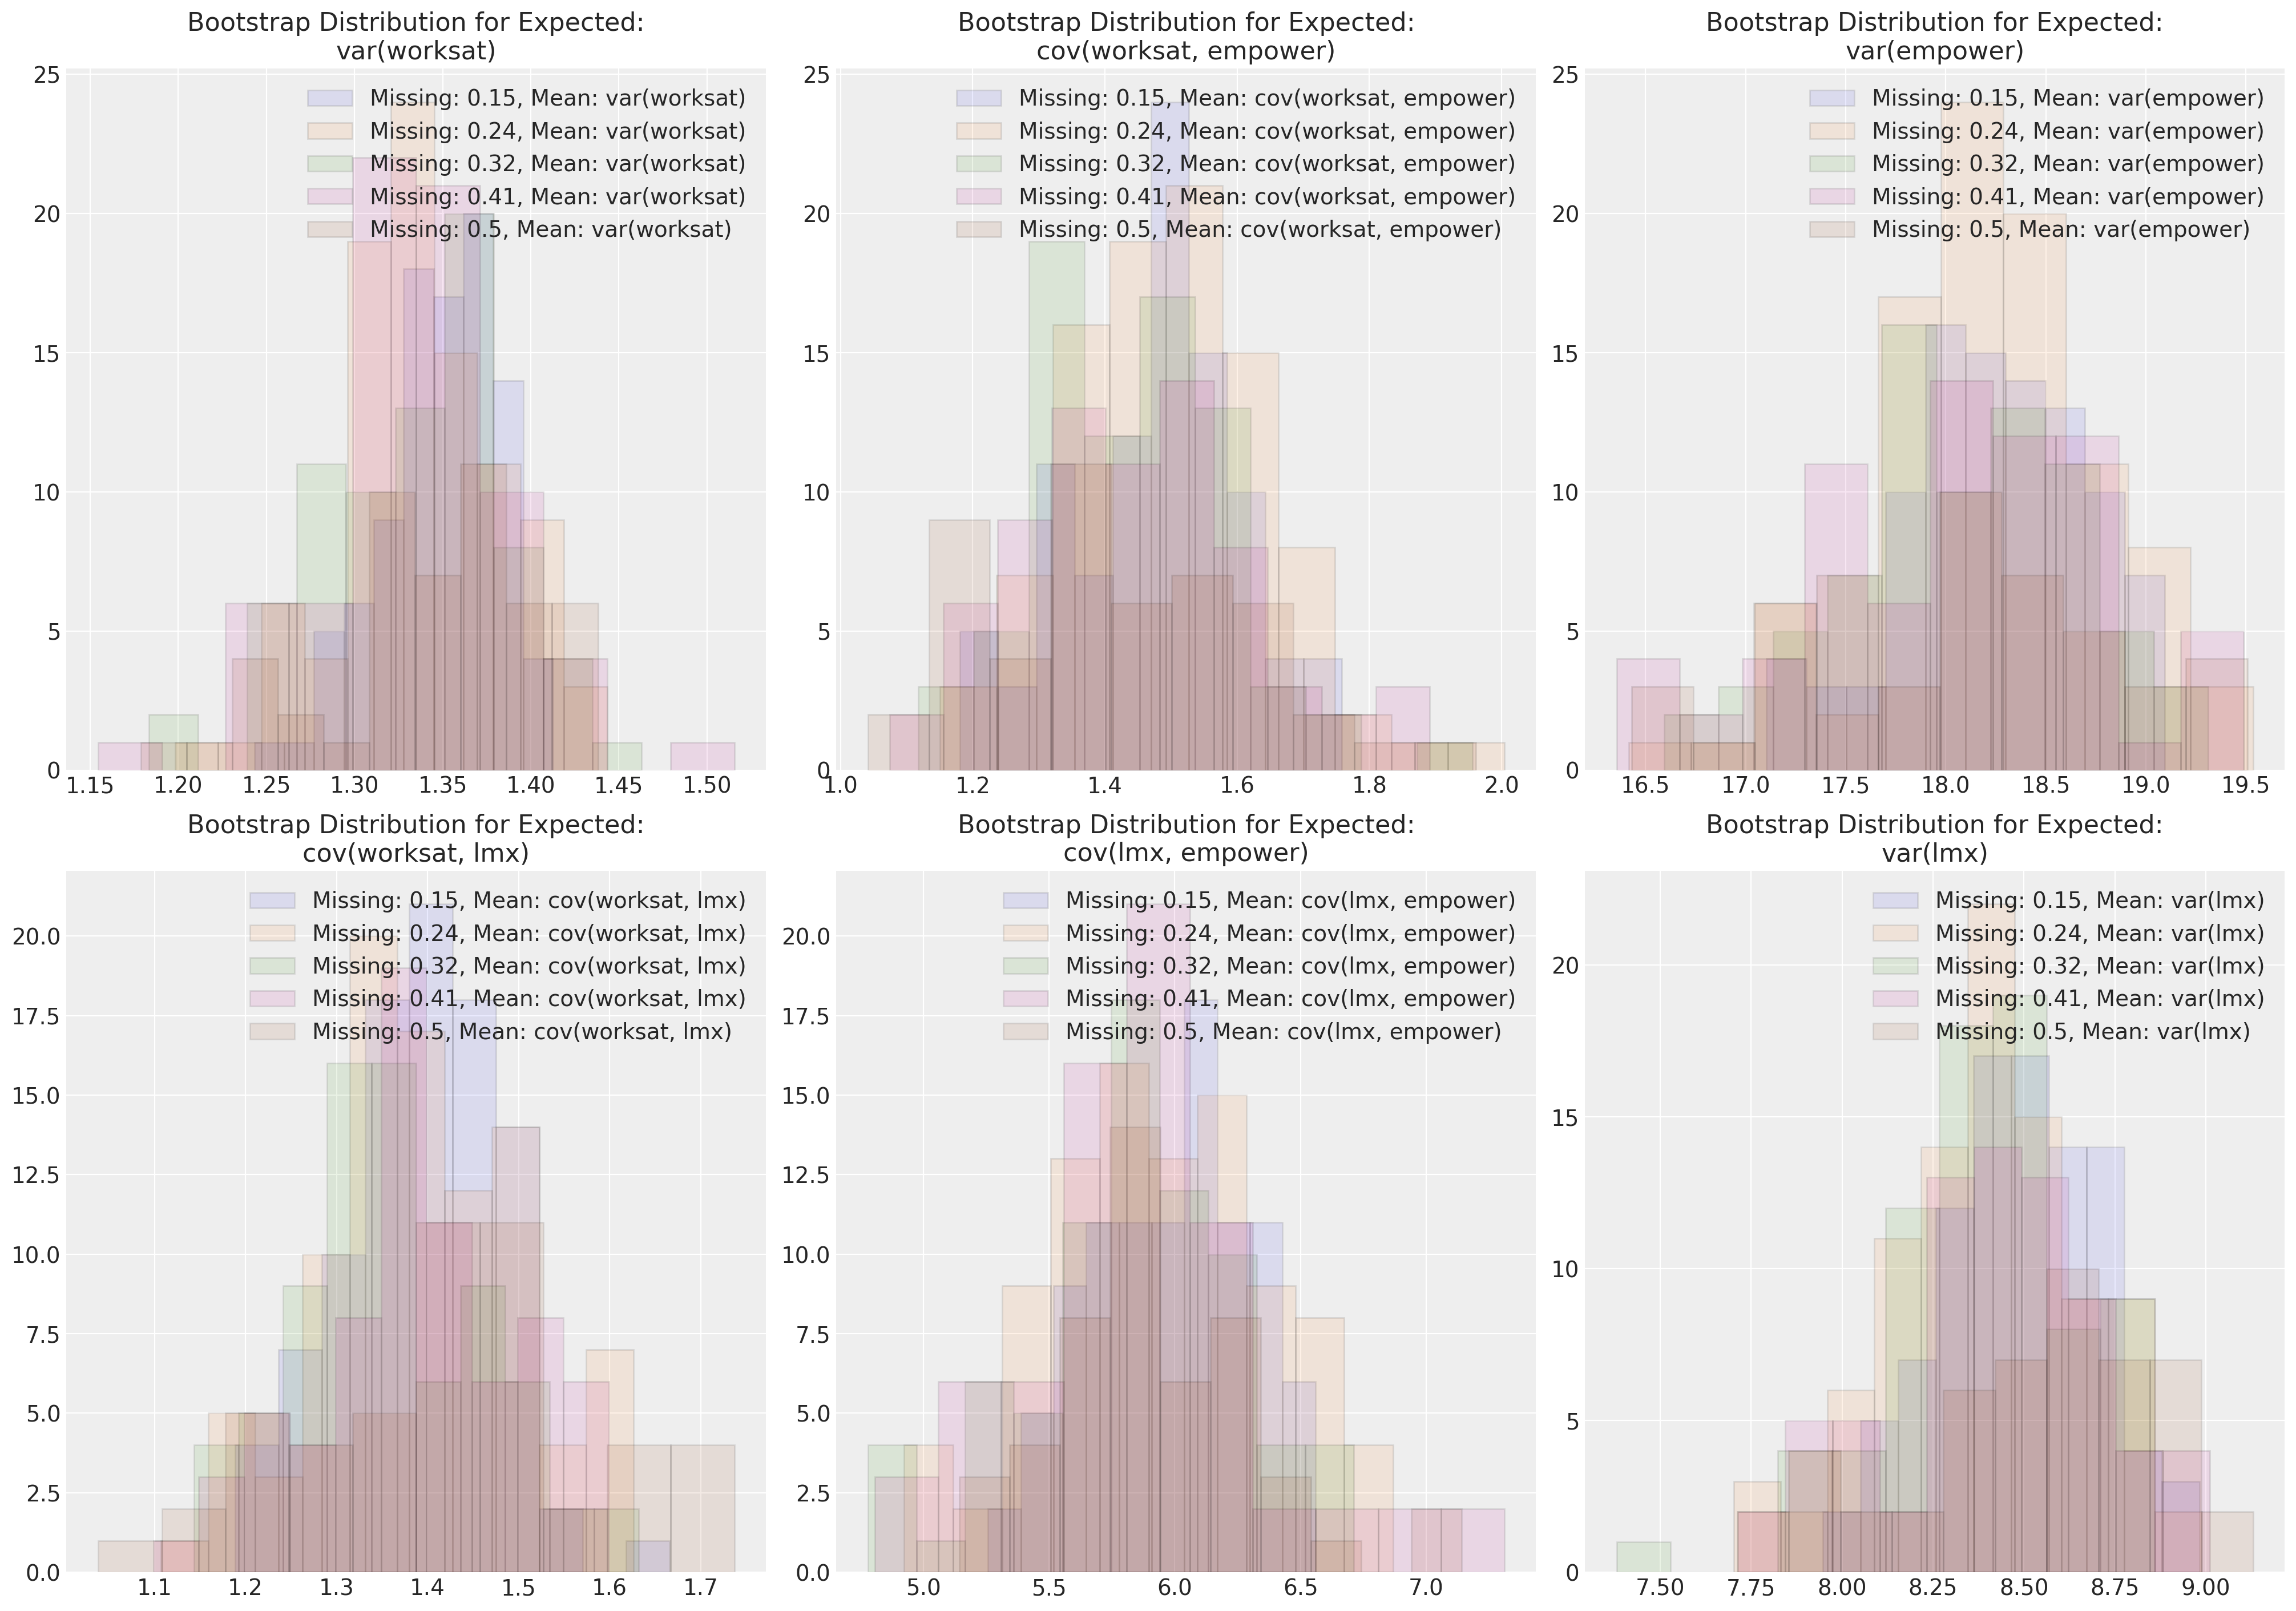

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(20, 14))
axs = axs.flatten()
for n in sensitivity.keys():
    length = len(sensitivity[n]["cov"])
    temp = pd.DataFrame(
        [sensitivity[n]["cov"][i][np.tril_indices(3)] for i in range(length)],
        columns=[
            "var(worksat)",
            "cov(worksat, empower)",
            "var(empower)",
            "cov(worksat, lmx)",
            "cov(lmx, empower)",
            "var(lmx)",
        ],
    )
    for col, ax in zip(temp.columns, axs):
        ax.hist(
            temp[col], alpha=0.1, ec="black", label=f"Missing: {np.round(n/200, 2)}, Mean: {col}"
        )
        ax.legend()
        ax.set_title(f"Bootstrap Distribution for Expected:\n{col}")

## Bayesian Imputation 

Next we'll apply bayesian methods to the same problem. But here we'll see direct imputation of the missing values using the posterior predictive distribution. 

/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_88650/3865616598.py:16: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata = pm.sample_prior_predictive()
Sampling: [cov, mus, x_unobs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]


/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mus, cov, x_unobs]


/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pytensor/compile/function/types.py:972: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
/var/folders/99/gp2xl6x513s0tvl3cx79zf7m0000gn/T/ipykernel_88650/3865616598.py:19: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  pm.sample_posterior_predictive(idata, extend_inferencedata=True)


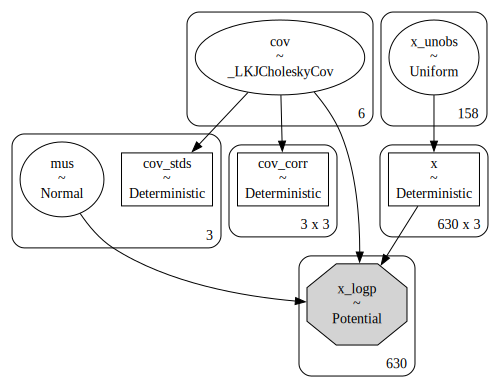

In [13]:
import pytensor.tensor as pt

with pm.Model() as model:
    # Priors
    mus = pm.Normal("mus", 0, 1, size=3)
    cov_flat_prior, _, _ = pm.LKJCholeskyCov("cov", n=3, eta=1.0, sd_dist=pm.Exponential.dist(1))
    # Create a vector of flat variables for the unobserved components of the MvNormal
    x_unobs = pm.Uniform("x_unobs", 0, 100, shape=(np.isnan(data.values).sum(),))

    # Create the symbolic value of x, combining observed data and unobserved variables
    x = pt.as_tensor(data.values)
    x = pm.Deterministic("x", pt.set_subtensor(x[np.isnan(data.values)], x_unobs))

    # Add a Potential with the logp of the variable conditioned on `x`
    pm.Potential("x_logp", pm.logp(rv=pm.MvNormal.dist(mus, chol=cov_flat_prior), value=x))
    idata = pm.sample_prior_predictive()
    idata = pm.sample()
    idata.extend(pm.sample(random_seed=120))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

pm.model_to_graphviz(model)

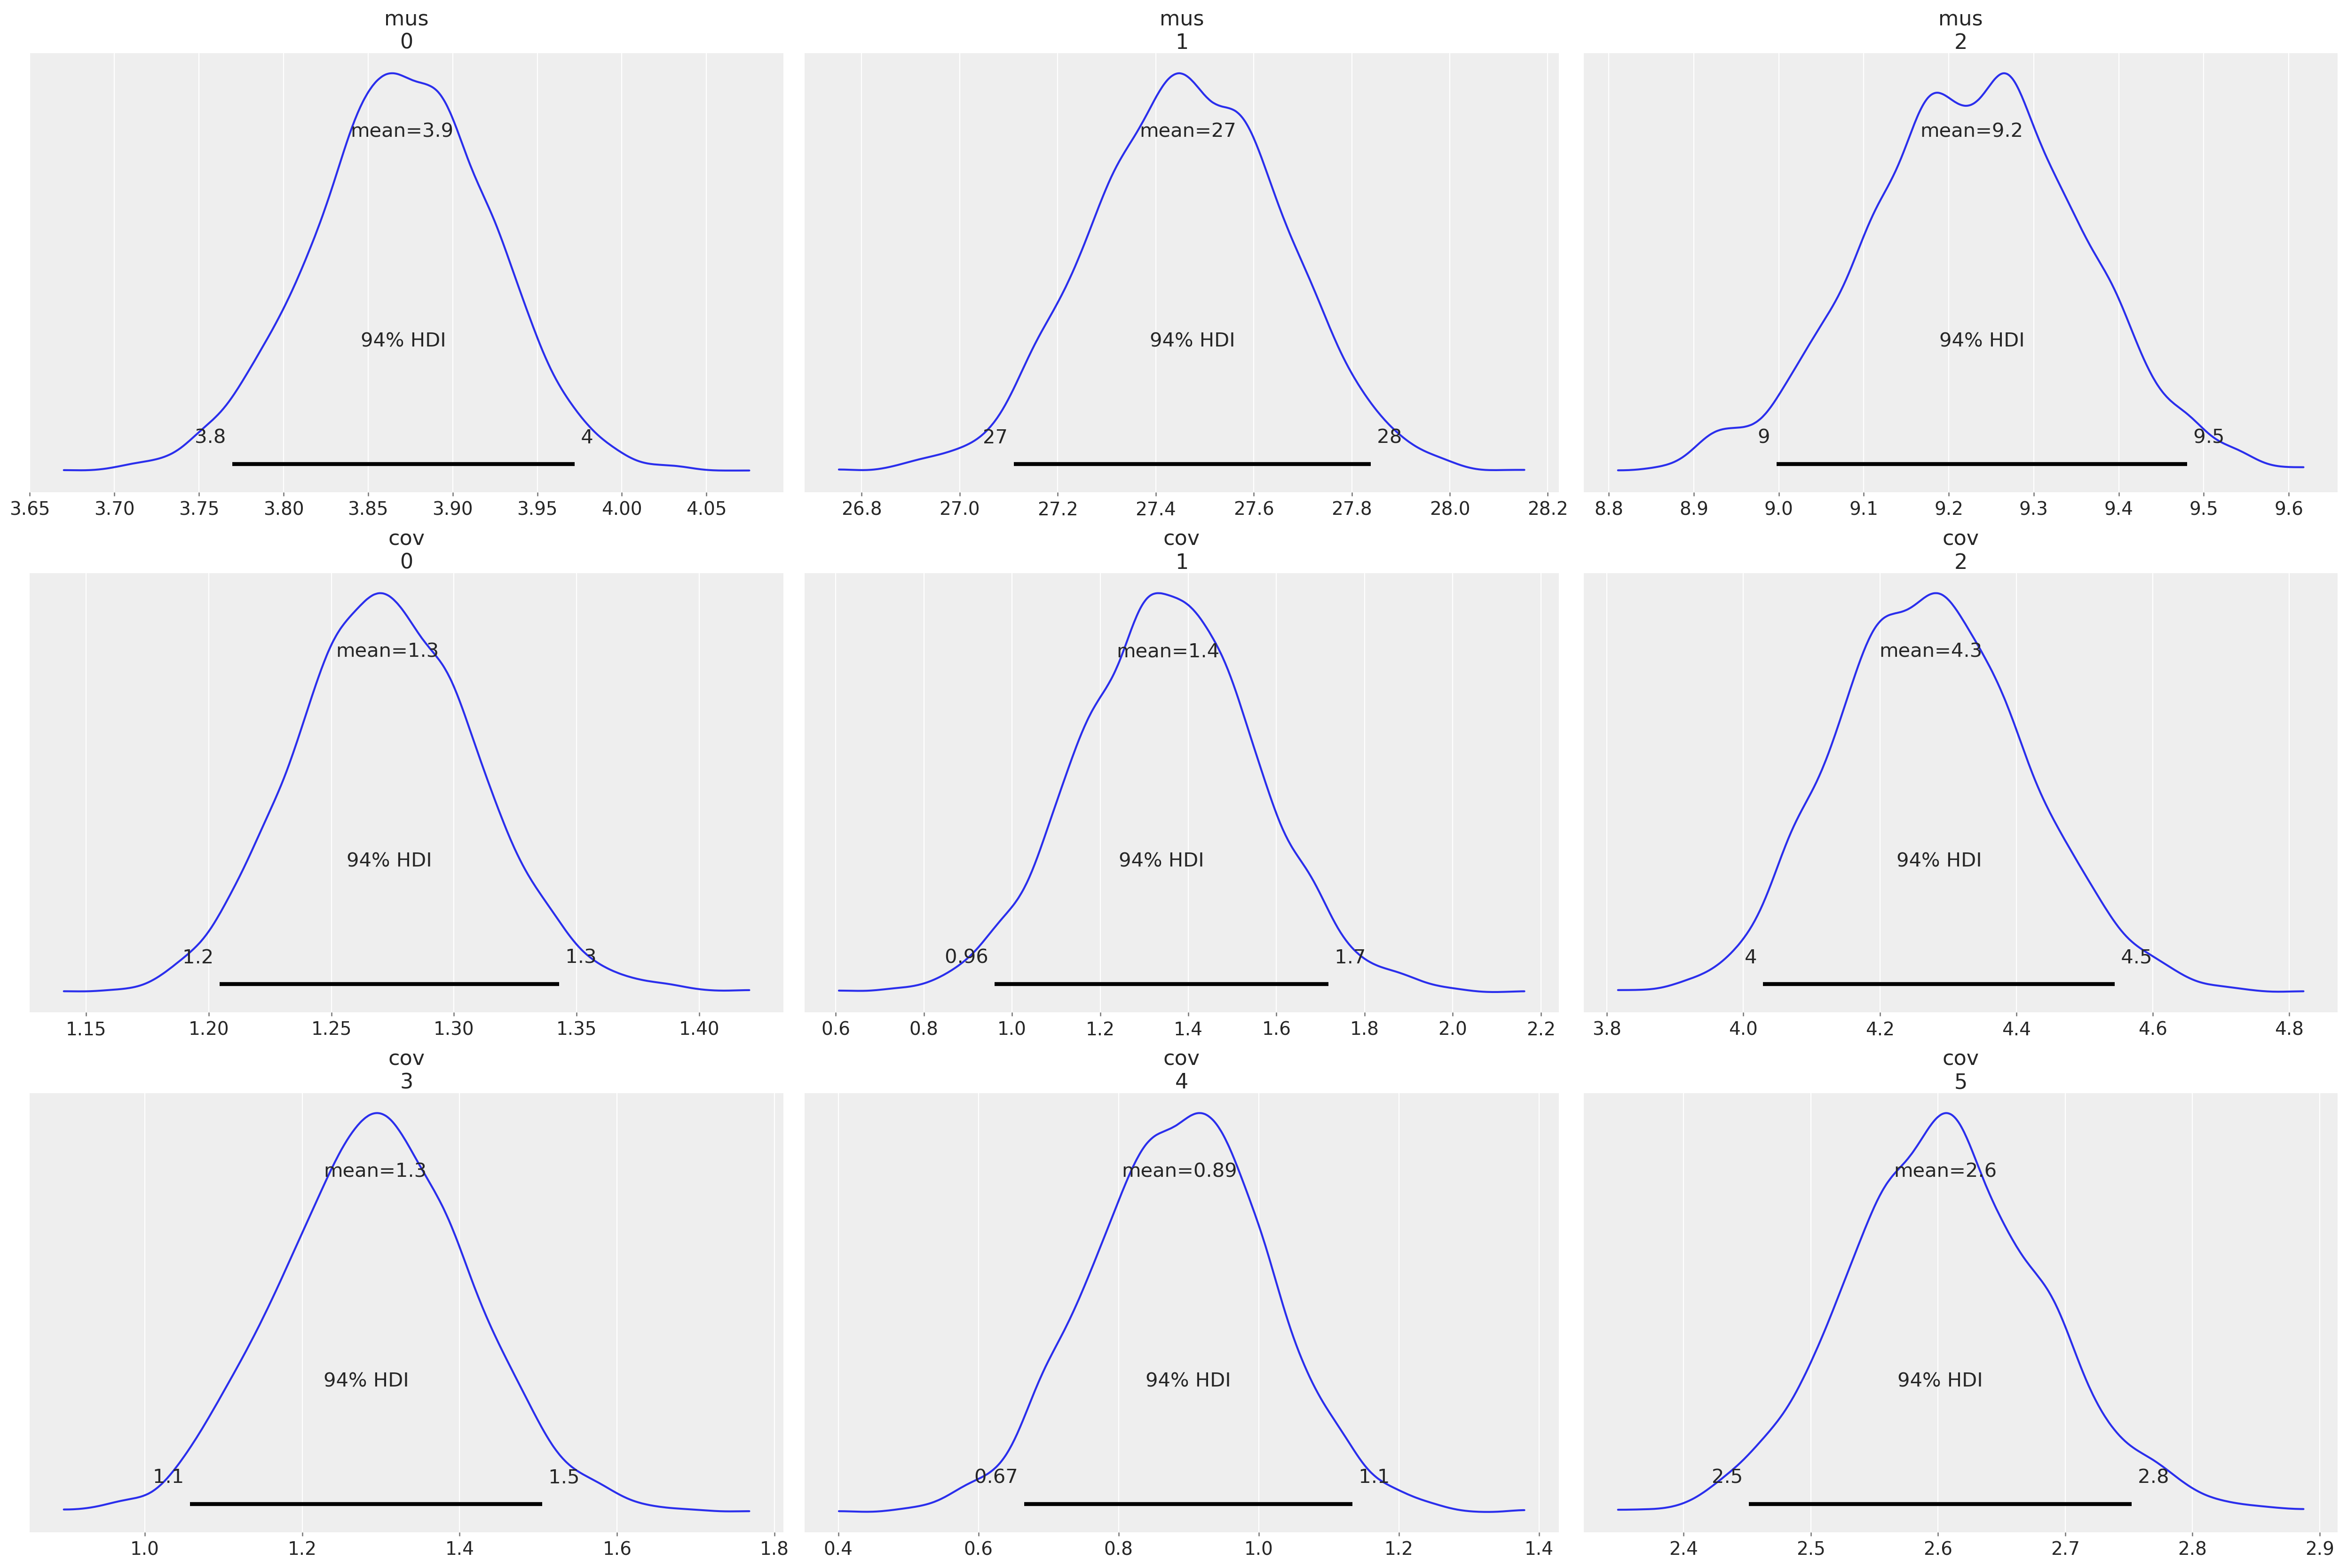

In [14]:
az.plot_posterior(idata, var_names=["mus", "cov"]);

In [15]:
az.summary(idata, var_names=["mus", "cov", "x_unobs"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mus[0]         3.870  0.054   3.770    3.972      0.001    0.000    6061.0   
mus[1]        27.466  0.198  27.111   27.838      0.002    0.002    6680.0   
mus[2]         9.227  0.127   8.998    9.480      0.002    0.001    6907.0   
cov[0]         1.273  0.037   1.204    1.343      0.000    0.000    6323.0   
cov[1]         1.354  0.202   0.961    1.718      0.003    0.002    5380.0   
...              ...    ...     ...      ...        ...      ...       ...   
x_unobs[153]  29.865  4.149  22.397   37.821      0.047    0.034    7691.0   
x_unobs[154]   2.572  1.076   0.459    4.556      0.022    0.016    2168.0   
x_unobs[155]  30.004  4.080  22.255   37.320      0.042    0.030    9328.0   
x_unobs[156]  29.587  3.996  21.695   36.754      0.043    0.031    8842.0   
x_unobs[157]  27.415  3.988  19.842   34.839      0.042    0.030    9050.0   

              ess_tail  r_hat  
mus[0]          3261.0    1.0  
mus[1]          3594.0    1.0  
mus[2]          3757.0    1.0  
cov[0]          3153.0    1.0  
cov[1]          3380.0    1.0  
...                ...    ...  
x_unobs[153]    2531.0    1.0  
x_unobs[154]     838.0    1.0  
x_unobs[155]    2500.0    1.0  
x_unobs[156]    2833.0    1.0  
x_unobs[157]    2502.0    1.0  

[167 rows x 9 columns]

In [16]:
imputed_dims = data.shape
imputed = data.values.flatten()
imputed[np.isnan(imputed)] = az.summary(idata, var_names=["x_unobs"])["mean"].values
imputed = imputed.reshape(imputed_dims[0], imputed_dims[1])
imputed = pd.DataFrame(imputed, columns=[col + "_imputed" for col in data.columns])
imputed.head(10)

worksat_imputed  empower_imputed  lmx_imputed
0            3.000           32.000       11.000
1            4.000           29.384       13.000
2            4.000           30.000        9.000
3            3.000           29.000        8.000
4            4.000           26.000        7.000
5            4.002           27.974       10.000
6            5.000           28.985       11.000
7            3.000           22.000        9.000
8            2.000           23.000        6.897
9            4.000           32.000        9.000

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20, 7))
axs = axs.flatten()
for col, col_i, ax in zip(data.columns, imputed.columns, axs):
    ax.hist(data[col], color="red", label=col, ec="black", bins=30)
    ax.hist(imputed[col_i], color="cyan", alpha=0.3, label=col_i, ec="black", bins=30)
    ax.legend()
    ax.set_title(f"Imputed Distribution and Observed for {col}")

In [18]:
pd.DataFrame(az.summary(idata, var_names=["cov_corr"])["mean"].values.reshape(3, 3))

/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/arviz/stats/diagnostics.py:584: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


0      1      2
0  1.000  0.301  0.424
1  0.301  1.000  0.405
2  0.424  0.405  1.000

## Bayesian Imputation by Chained Equations

So far we've seen multivariate approaches to imputation which treat each of the variables in our dataset as a collection drawn from the same distribution. However, there is a more flexible approach which is often useful when there is a particular focal relationship that we're interested in analysing. 

Sticking with the employee data set we'll examine here the relationship between `lmx`, `climate`, `male` and `empower`, where our focus is on what drives empowerment. 
Recall that our gender variable `male` is fully specified and does not need to be imputed. So we have a joint distribution:

$$ f(emp, lmx, climate, male) = f(emp | lmx, climate, male) \cdot f(lmx | climate, male) \cdot f(climate | male) \cdot f(male)^{*} $$

which can be split out into individual regression equations or more generally component models for each required conditional model. 

$$ empower = \alpha_{2} + \beta_{3}male + \beta_{4}climate + \beta_{5}lmx $$
$$ lmx = \alpha_{1} + \beta_{1}climate + \beta_{2}male $$
$$ climate = \alpha_{0} + \beta_{0}male $$

We can impute each of these equations in turn saving the imputed data set and feeding it forward into the next modelling exercise. This adds a little complexity because some of the variables will occur twice. Once as a predictor in our focal and onces a likelihood term in their own component model. 



In [19]:
data = df_employee[["lmx", "empower", "climate", "male"]]
data

lmx  empower  climate  male
0    11.0     32.0     18.0     1
1    13.0      NaN     18.0     1
2     9.0     30.0     18.0     1
3     8.0     29.0     18.0     1
4     7.0     26.0     18.0     0
..    ...      ...      ...   ...
625   5.0     28.0     21.0     0
626   5.0     17.0     21.0     0
627  10.0     28.0     21.0     1
628   9.0      NaN     21.0     0
629   5.0     32.0     21.0     1

[630 rows x 4 columns]

### PYMC Imputation

As we saw above we can use PYMC to impute the values of missing data by using a particular samping distribution. In the case of chained equations this becomes a little trickier because we might want to use both the data for `lmx` as a regressor in one equation and observed data in our likelihood in another. 

It also matters how we specify the sampling distribution that will be used to impute our missing data. We'll show an example here where we use a uniform and normal sampling distribution alternatively for imputing the predictor terms in our in focal regression. 


/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in climate_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in lmx_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in lmx_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Dat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 95 seconds.
Sampling: [climate_imputed_observed, climate_pred_observed, emp_imputed_missing, emp_imputed_observed, lmx_imputed_missing, lmx_imputed_observed, lmx_pred_observed]


/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in climate_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in lmx_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Data in lmx_imputed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/nathanielforde/opt/miniconda3/envs/missing_data_clean/lib/python3.11/site-packages/pymc/model.py:1400: ImputationWarning: Dat

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 100 seconds.
Sampling: [climate_imputed_observed, climate_pred_observed, emp_imputed_missing, emp_imputed_observed, lmx_imputed_missing, lmx_imputed_observed, lmx_pred_observed]


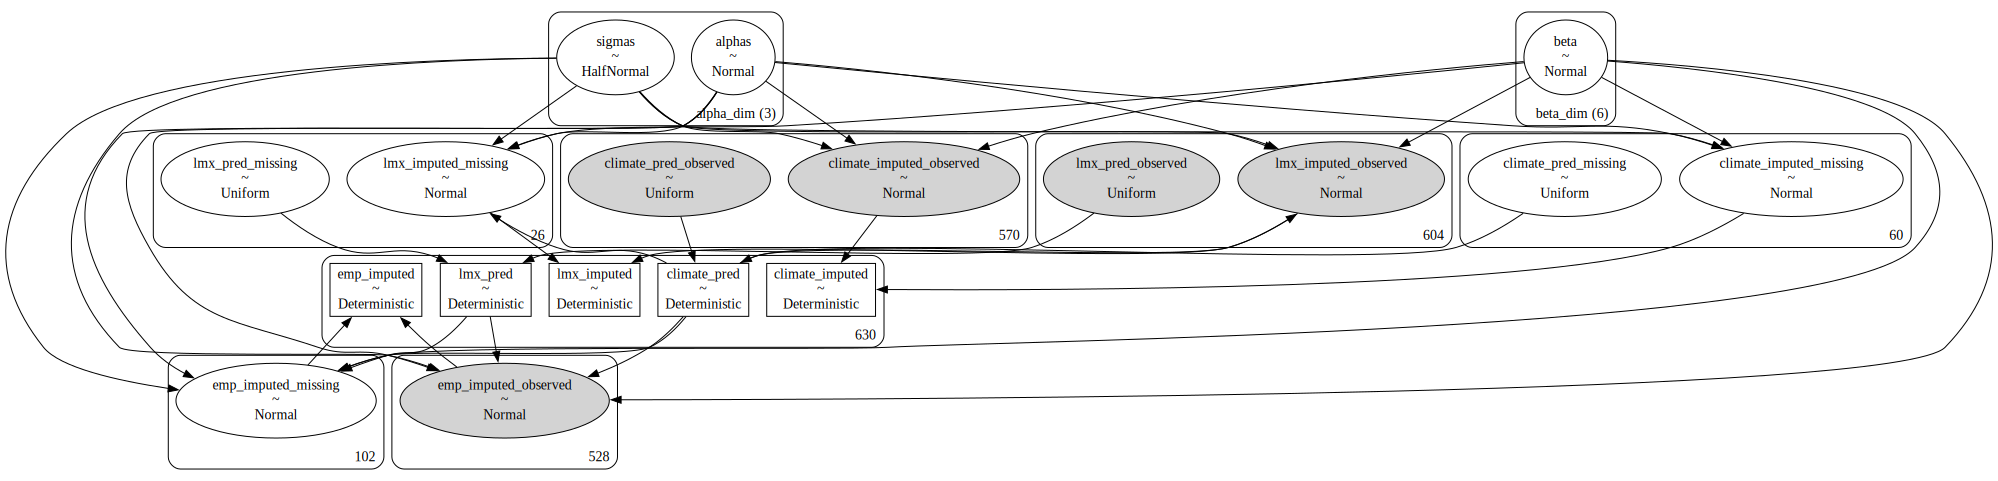

In [20]:
lmx_mean = data["lmx"].mean()
lmx_min = data["lmx"].min()
lmx_max = data["lmx"].max()
lmx_sd = data["lmx"].std()

cli_mean = data["climate"].mean()
cli_min = data["climate"].min()
cli_max = data["climate"].max()
cli_sd = data["climate"].std()


priors = {
    "climate": {"normal": [lmx_mean, lmx_sd, lmx_sd], "uniform": [lmx_min, lmx_max]},
    "lmx": {"normal": [cli_mean, cli_sd, cli_sd], "uniform": [cli_min, cli_max]},
}


def make_model(priors, normal_pred_assumption=True):

    coords = {
        "alpha_dim": ["lmx_imputed", "climate_imputed", "empower_imputed"],
        "beta_dim": [
            "lmxB_male",
            "lmxB_climate",
            "climateB_male",
            "empB_male",
            "empB_climate",
            "empB_lmx",
        ],
    }
    with pm.Model(coords=coords) as model:
        # Priors
        beta = pm.Normal("beta", 0, 1, size=6, dims="beta_dim")
        alpha = pm.Normal("alphas", 10, 5, size=3, dims="alpha_dim")
        sigma = pm.HalfNormal("sigmas", 5, size=3, dims="alpha_dim")

        if normal_pred_assumption:
            mu_climate = pm.Normal(
                "mu_climate", priors["climate"]["normal"][0], priors["climate"]["normal"][1]
            )
            sigma_climate = pm.HalfNormal("sigma_climate", priors["climate"]["normal"][2])
            climate_pred = pm.Normal(
                "climate_pred", mu_climate, sigma_climate, observed=data["climate"].values
            )
        else:
            climate_pred = pm.Uniform("climate_pred", 0, 40, observed=data["climate"].values)

        if normal_pred_assumption:
            mu_lmx = pm.Normal("mu_lmx", priors["lmx"]["normal"][0], priors["lmx"]["normal"][1])
            sigma_lmx = pm.HalfNormal("sigma_lmx", priors["lmx"]["normal"][2])
            lmx_pred = pm.Normal("lmx_pred", mu_lmx, sigma_lmx, observed=data["lmx"].values)
        else:
            lmx_pred = pm.Uniform("lmx_pred", 0, 40, observed=data["lmx"].values)

        # Likelihood(s)
        lmx_imputed = pm.Normal(
            "lmx_imputed",
            alpha[0] + beta[0] * data["male"] + beta[1] * climate_pred,
            sigma[0],
            observed=data["lmx"].values,
        )
        climate_imputed = pm.Normal(
            "climate_imputed",
            alpha[1] + beta[2] * data["male"],
            sigma[1],
            observed=data["climate"].values,
        )
        empower_imputed = pm.Normal(
            "emp_imputed",
            alpha[2] + beta[3] * data["male"] + beta[4] * climate_pred + beta[5] * lmx_pred,
            sigma[2],
            observed=data["empower"].values,
        )

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(random_seed=120))
        pm.sample_posterior_predictive(idata, extend_inferencedata=True)
        return idata, model


idata_uniform, model_uniform = make_model(priors, normal_pred_assumption=False)
idata_normal, model_normal = make_model(priors, normal_pred_assumption=True)
pm.model_to_graphviz(model_uniform)

In [21]:
idata_uniform

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [22]:
idata_normal

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

### Model Fits

In [23]:
az.summary(idata_normal, var_names=["alphas", "beta", "sigmas"], stat_focus="median")

median    mad  eti_3%  eti_97%  mcse_median  \
alphas[lmx_imputed]       9.057  0.446   7.854   10.263        0.011   
alphas[climate_imputed]  19.776  0.158  19.345   20.213        0.005   
alphas[empower_imputed]  17.928  0.689  16.016   19.851        0.022   
beta[lmxB_male]           0.437  0.157  -0.005    0.894        0.003   
beta[lmxB_climate]        0.018  0.022  -0.042    0.076        0.001   
beta[climateB_male]       0.696  0.214   0.092    1.286        0.006   
beta[empB_male]           1.656  0.214   1.043    2.254        0.005   
beta[empB_climate]        0.203  0.030   0.121    0.286        0.001   
beta[empB_lmx]            0.598  0.039   0.489    0.710        0.001   
sigmas[lmx_imputed]       3.023  0.059   2.865    3.199        0.001   
sigmas[climate_imputed]   4.021  0.077   3.812    4.251        0.002   
sigmas[empower_imputed]   3.815  0.079   3.598    4.052        0.002   

                         ess_median  ess_tail  r_hat  
alphas[lmx_imputed]        3920.446    3077.0   1.00  
alphas[climate_imputed]    4203.071    3452.0   1.00  
alphas[empower_imputed]    3143.699    3063.0   1.00  
beta[lmxB_male]            7104.804    3102.0   1.00  
beta[lmxB_climate]         3670.069    2911.0   1.00  
beta[climateB_male]        4471.550    3328.0   1.00  
beta[empB_male]            5282.112    3361.0   1.00  
beta[empB_climate]         3395.600    3068.0   1.00  
beta[empB_lmx]             4541.732    2991.0   1.00  
sigmas[lmx_imputed]        5408.426    3360.0   1.00  
sigmas[climate_imputed]    5084.700    3347.0   1.01  
sigmas[empower_imputed]    4530.686    3042.0   1.00

In [24]:
az.summary(idata_uniform, var_names=["alphas", "beta", "sigmas"], stat_focus="median")

median    mad  eti_3%  eti_97%  mcse_median  \
alphas[lmx_imputed]       9.159  0.402   8.082   10.230        0.015   
alphas[climate_imputed]  19.781  0.159  19.339   20.219        0.004   
alphas[empower_imputed]  18.855  0.645  17.070   20.708        0.026   
beta[lmxB_male]           0.433  0.166   0.013    0.867        0.003   
beta[lmxB_climate]        0.013  0.019  -0.039    0.065        0.001   
beta[climateB_male]       0.689  0.224   0.067    1.284        0.006   
beta[empB_male]           1.625  0.215   1.025    2.230        0.005   
beta[empB_climate]        0.206  0.025   0.130    0.275        0.001   
beta[empB_lmx]            0.488  0.044   0.363    0.608        0.001   
sigmas[lmx_imputed]       3.020  0.058   2.874    3.186        0.001   
sigmas[climate_imputed]   4.018  0.081   3.808    4.252        0.002   
sigmas[empower_imputed]   3.783  0.082   3.572    4.029        0.002   

                         ess_median  ess_tail  r_hat  
alphas[lmx_imputed]        3450.523    3292.0    1.0  
alphas[climate_imputed]    4512.068    3360.0    1.0  
alphas[empower_imputed]    2292.646    2706.0    1.0  
beta[lmxB_male]            6325.253    3040.0    1.0  
beta[lmxB_climate]         3197.124    3042.0    1.0  
beta[climateB_male]        4576.652    3231.0    1.0  
beta[empB_male]            6056.623    3056.0    1.0  
beta[empB_climate]         3166.040    2923.0    1.0  
beta[empB_lmx]             2428.278    2756.0    1.0  
sigmas[lmx_imputed]        7159.549    3040.0    1.0  
sigmas[climate_imputed]    6092.150    2921.0    1.0  
sigmas[empower_imputed]    4046.865    2845.0    1.0

We can see how the choice of sampling distribution has induced different parameter estimates on the beta coefficients across our two models. 

array([<AxesSubplot: >], dtype=object)

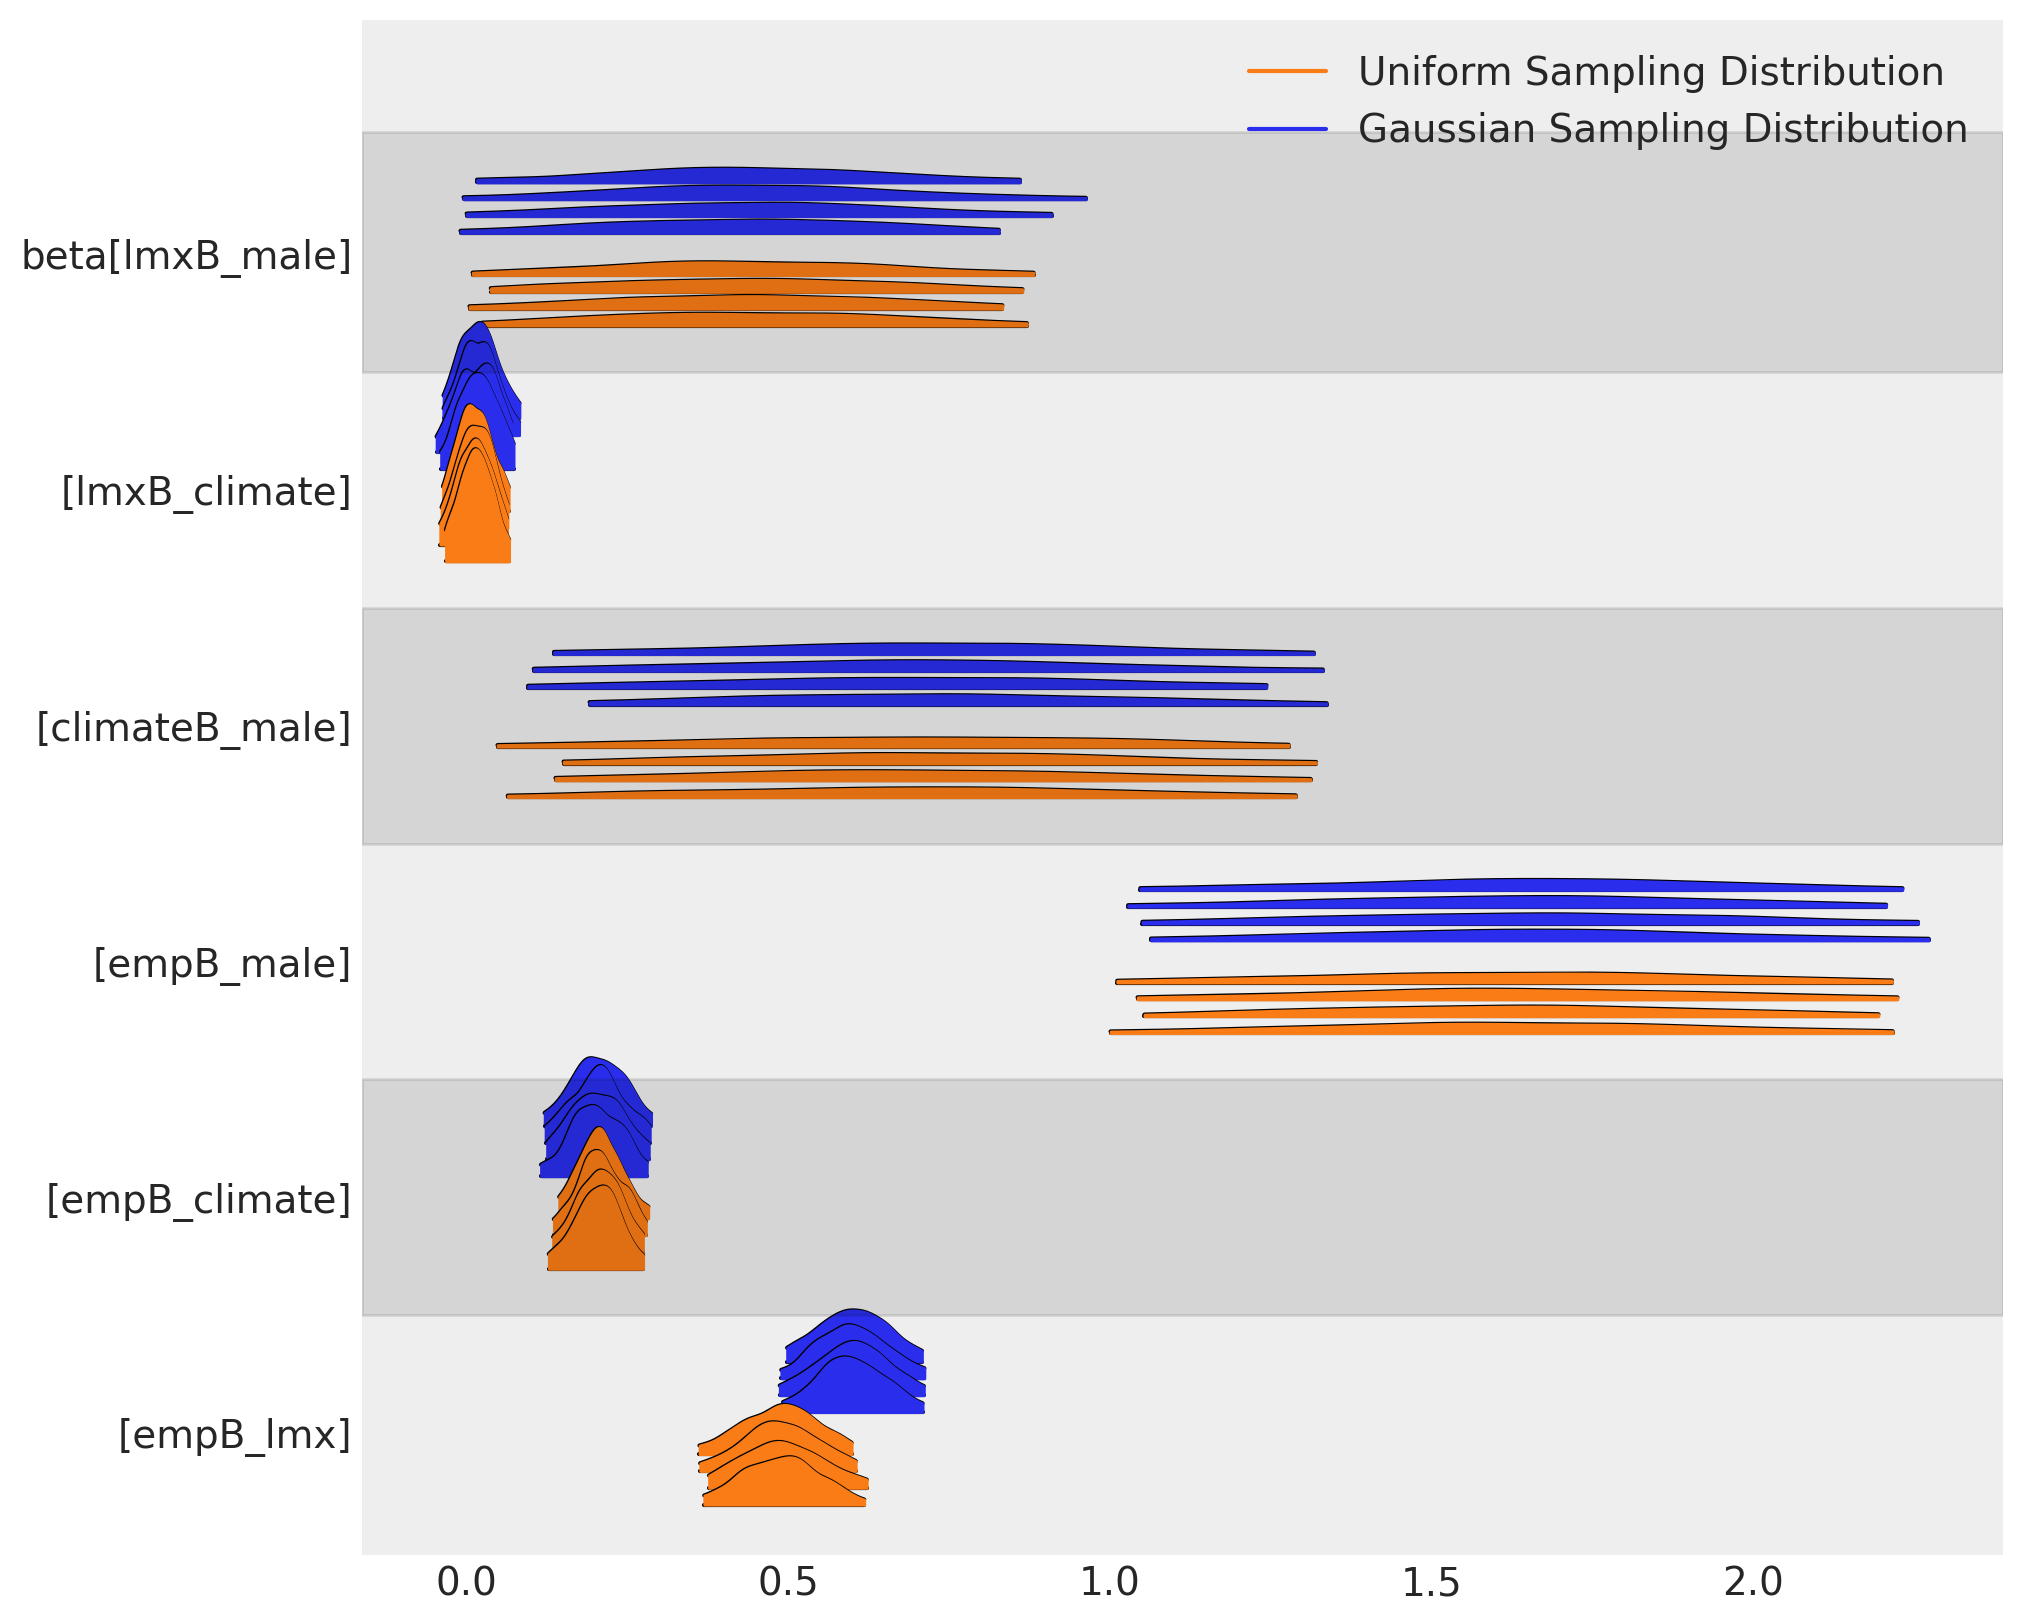

In [25]:
az.plot_forest(
    [idata_normal, idata_uniform],
    var_names=["beta"],
    kind="ridgeplot",
    model_names=["Gaussian Sampling Distribution", "Uniform Sampling Distribution"],
    figsize=(10, 8),
)

This difference has downstream effects on the posterior predictive distribution. We can see here how the sampling distribution for the predictor terms influences the posterior predictive fits on our focal regression equation.

### Posterior Predictive Distributions

In [26]:
az.plot_ppc(idata_uniform)

array([[<AxesSubplot: xlabel='climate_pred_observed / climate_pred_observed'>,
        <AxesSubplot: xlabel='lmx_pred_observed / lmx_pred_observed'>,
        <AxesSubplot: xlabel='lmx_imputed_observed / lmx_imputed_observed'>],
       [<AxesSubplot: xlabel='climate_imputed_observed / climate_imputed_observed'>,
        <AxesSubplot: xlabel='emp_imputed_observed / emp_imputed_observed'>,
        <AxesSubplot: >]], dtype=object)

array([[<AxesSubplot: xlabel='climate_pred_observed / climate_pred_observed'>,
        <AxesSubplot: xlabel='lmx_pred_observed / lmx_pred_observed'>,
        <AxesSubplot: xlabel='lmx_imputed_observed / lmx_imputed_observed'>],
       [<AxesSubplot: xlabel='climate_imputed_observed / climate_imputed_observed'>,
        <AxesSubplot: xlabel='emp_imputed_observed / emp_imputed_observed'>,
        <AxesSubplot: >]], dtype=object)

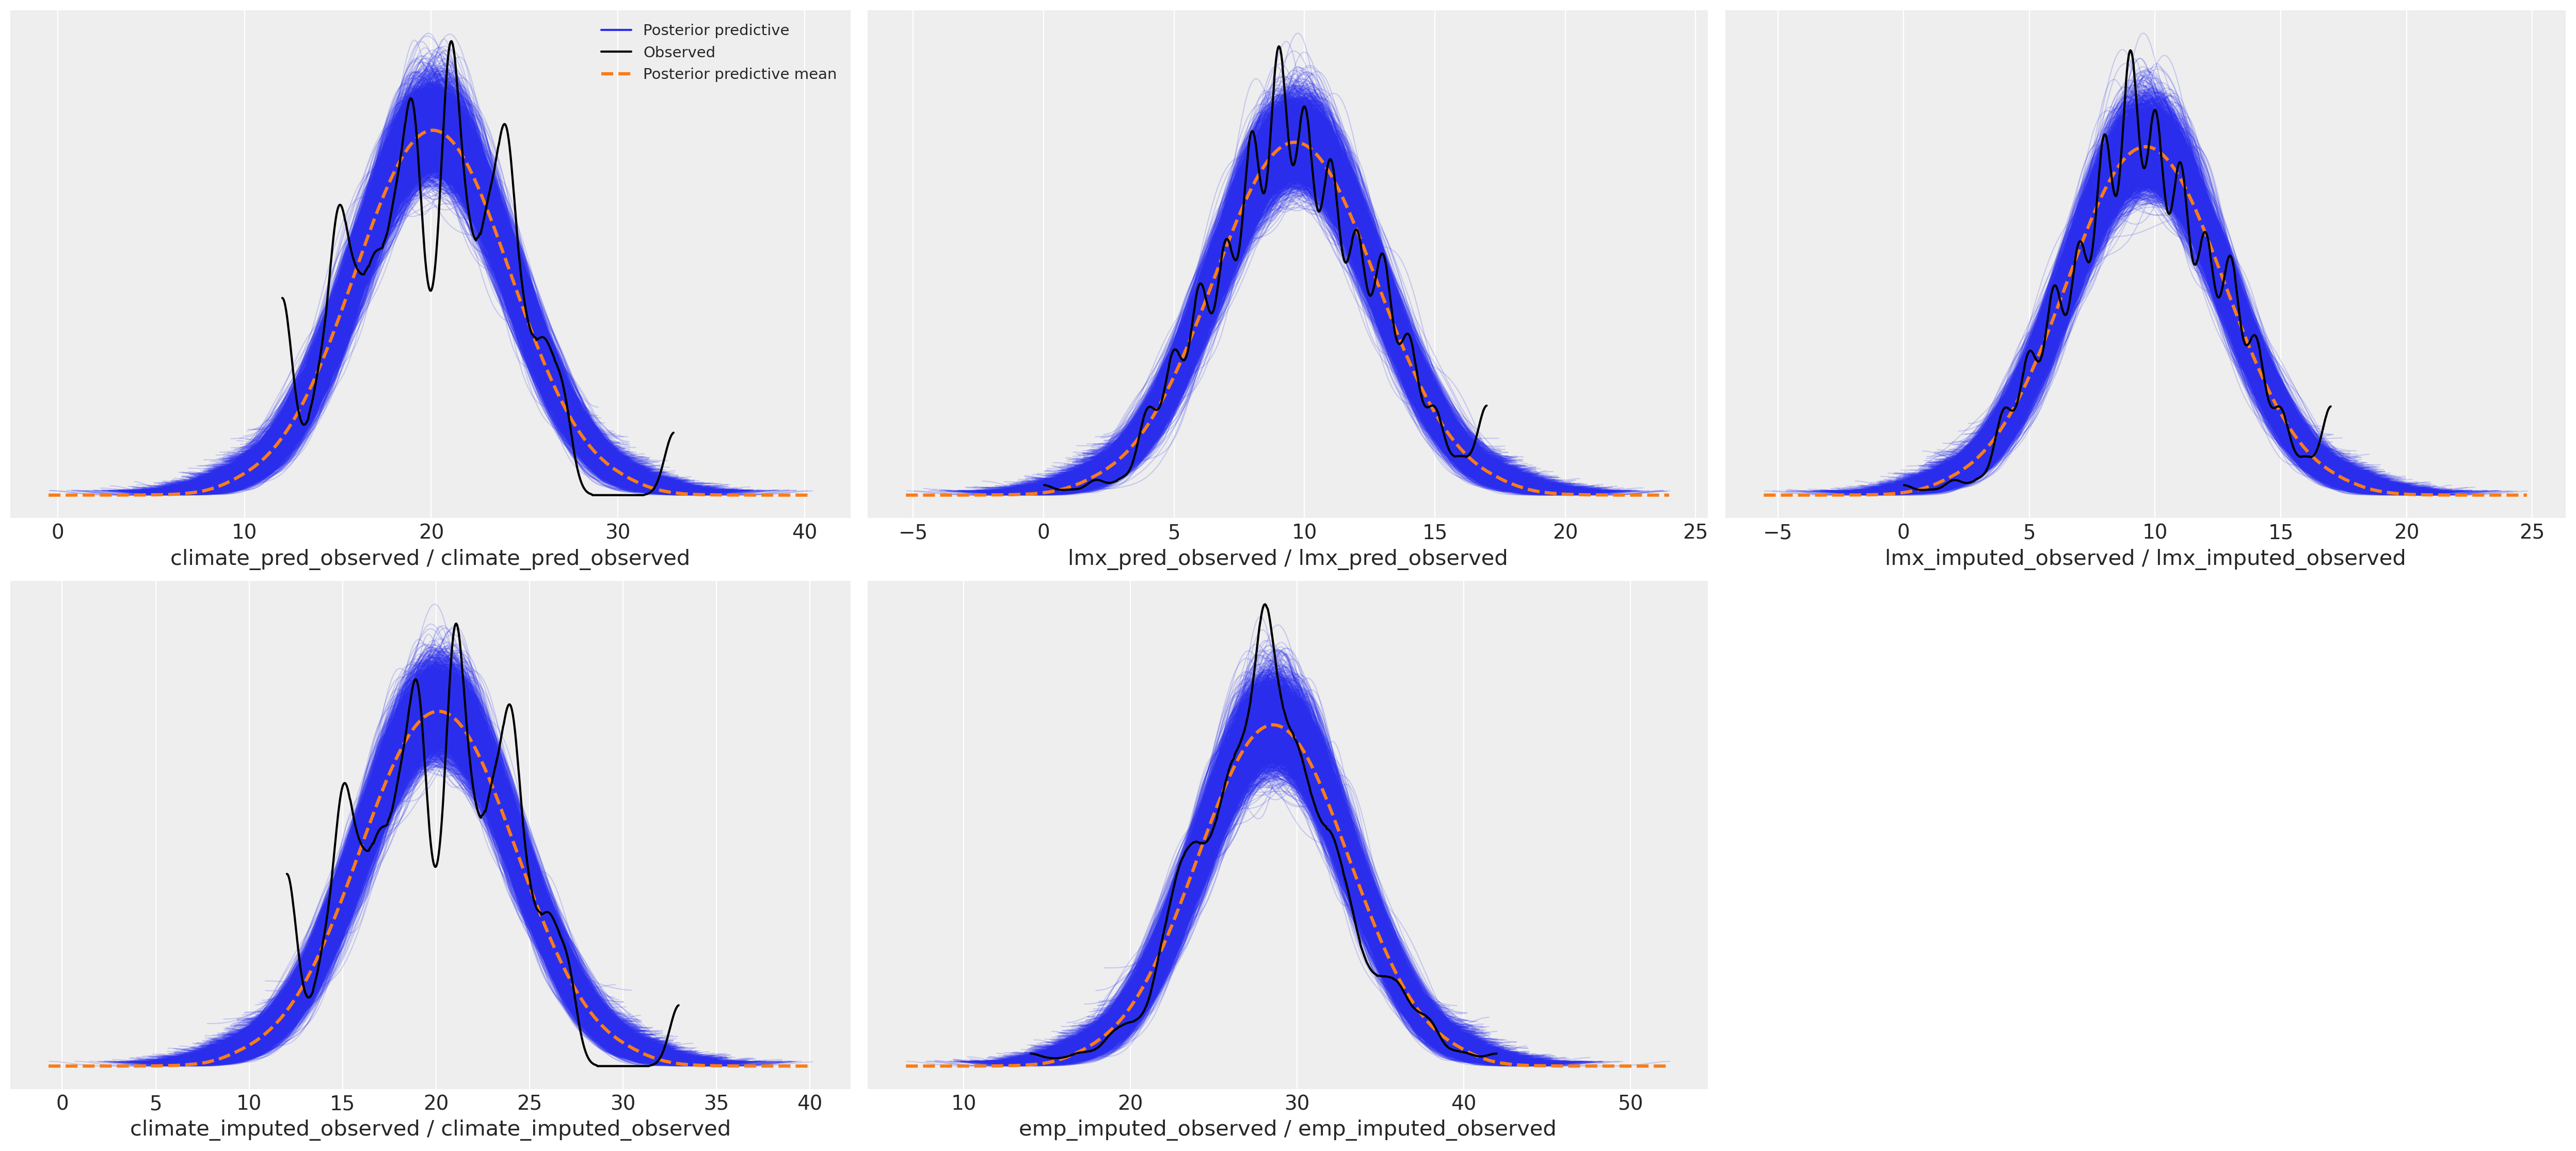

In [27]:
az.plot_ppc(idata_normal)

### Process the Posterior Predictive Distribution

In [28]:
def get_imputed(idata, data):
    imputed_data = data.copy()
    imputed_climate = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "climate_imputed"
    ].mean(axis=1)
    mask = imputed_data["climate"].isnull()
    imputed_data.loc[mask, "climate"] = imputed_climate.values[imputed_data[mask].index]

    imputed_lmx = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "lmx_imputed"
    ].mean(axis=1)
    mask = imputed_data["lmx"].isnull()
    imputed_data.loc[mask, "lmx"] = imputed_lmx.values[imputed_data[mask].index]

    imputed_emp = az.extract(idata, group="posterior_predictive", num_samples=1000)[
        "emp_imputed"
    ].mean(axis=1)
    mask = imputed_data["empower"].isnull()
    imputed_data.loc[mask, "empower"] = imputed_emp.values[imputed_data[mask].index]
    assert imputed_data.isnull().sum().to_list() == [0, 0, 0, 0]
    imputed_data.columns = ["imputed_" + col for col in imputed_data.columns]
    return imputed_data


imputed_data_uniform = get_imputed(idata_uniform, data)
imputed_data_normal = get_imputed(idata_normal, data)
imputed_data_uniform

imputed_lmx  imputed_empower  imputed_climate  imputed_male
0           11.0        32.000000             18.0             1
1           13.0        34.479170             18.0             1
2            9.0        30.000000             18.0             1
3            8.0        29.000000             18.0             1
4            7.0        26.000000             18.0             0
..           ...              ...              ...           ...
625          5.0        28.000000             21.0             0
626          5.0        17.000000             21.0             0
627         10.0        28.000000             21.0             1
628          9.0        32.839058             21.0             0
629          5.0        32.000000             21.0             1

[630 rows x 4 columns]

### Plotting the Imputed Datasets

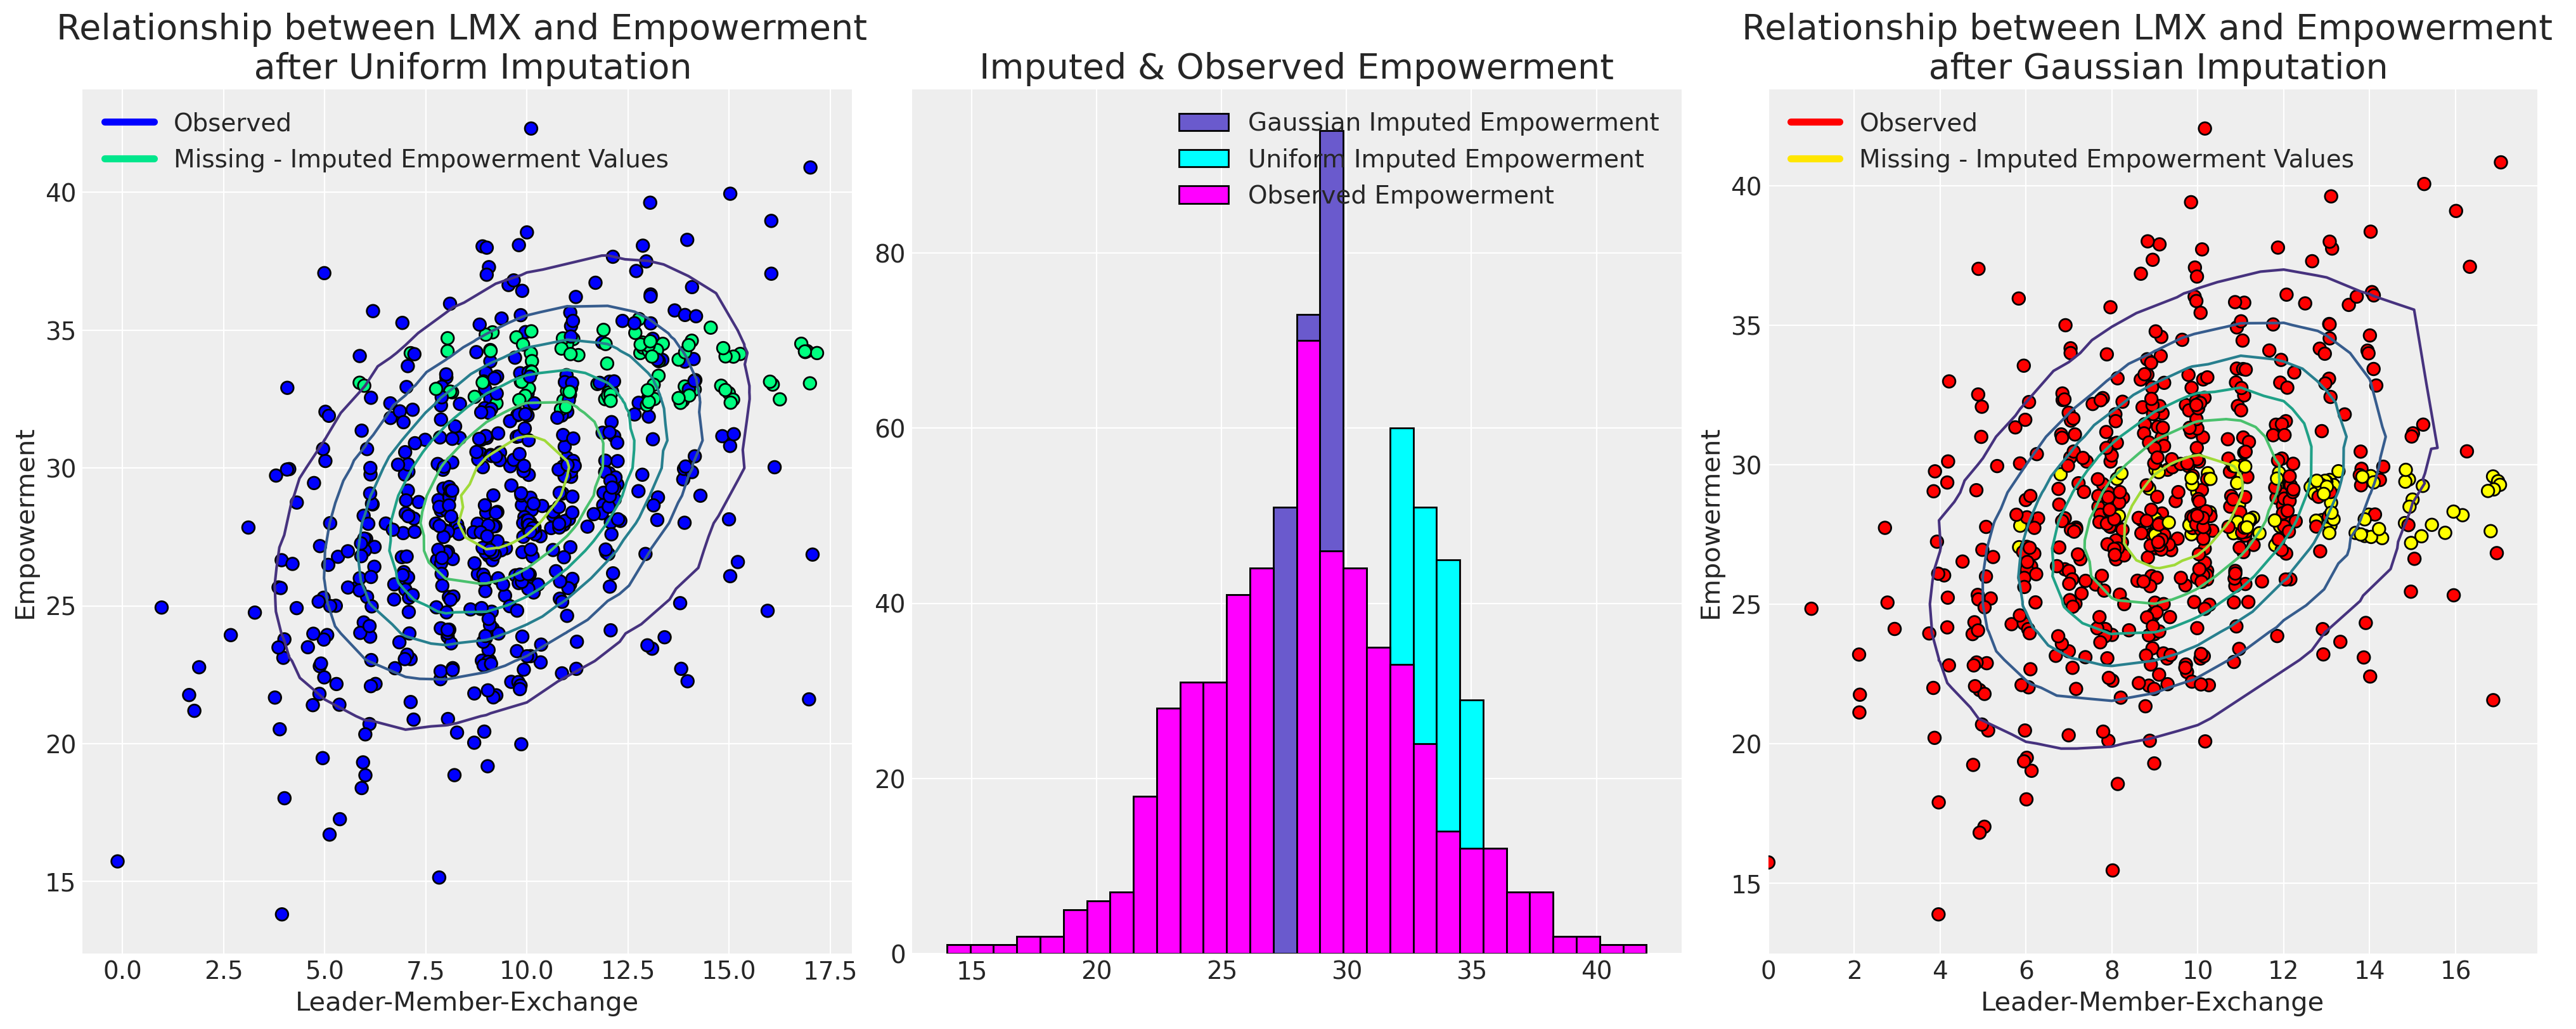

In [29]:
import matplotlib.cm as cm

joined_uniform = pd.concat([imputed_data_uniform, data], axis=1)
joined_normal = pd.concat([imputed_data_normal, data], axis=1)
for col in ["lmx", "empower", "climate"]:
    joined_uniform[col + "_missing"] = np.where(joined_uniform[col].isnull(), 1, 0)
    joined_normal[col + "_missing"] = np.where(joined_normal[col].isnull(), 1, 0)


def rand_jitter(arr):
    stdev = 0.01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev


fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
ax2 = axs[2]

## Derived from MV norm fit.
z = multivariate_normal(
    [lmx_mean, joined_uniform["imputed_empower"].mean()], [[8.9, 5.4], [5.4, 19]]
).pdf(joined_uniform[["imputed_lmx", "imputed_empower"]])

ax.scatter(
    rand_jitter(joined_uniform["imputed_lmx"]),
    rand_jitter(joined_uniform["imputed_empower"]),
    c=joined_uniform["empower_missing"],
    cmap=cm.winter,
    ec="black",
    s=50,
)
ax.set_title("Relationship between LMX and Empowerment \n after Uniform Imputation", fontsize=20)
ax.tricontour(joined_uniform["imputed_lmx"], joined_uniform["imputed_empower"], z)
ax.set_xlabel("Leader-Member-Exchange")
ax.set_ylabel("Empowerment")


custom_lines = [
    Line2D([0], [0], color=cm.winter(0.0), lw=4),
    Line2D([0], [0], color=cm.winter(0.9), lw=4),
]
ax.legend(custom_lines, ["Observed", "Missing - Imputed Empowerment Values"])

z = multivariate_normal(
    [lmx_mean, joined_normal["imputed_empower"].mean()], [[8.9, 5.4], [5.4, 19]]
).pdf(joined_normal[["imputed_lmx", "imputed_empower"]])

ax2.scatter(
    rand_jitter(joined_normal["imputed_lmx"]),
    rand_jitter(joined_normal["imputed_empower"]),
    c=joined_normal["empower_missing"],
    cmap=cm.autumn,
    ec="black",
    s=50,
)
ax2.set_title("Relationship between LMX and Empowerment \n after Gaussian Imputation", fontsize=20)
ax2.tricontour(joined_normal["imputed_lmx"], joined_normal["imputed_empower"], z)
ax2.set_xlabel("Leader-Member-Exchange")
ax2.set_ylabel("Empowerment")
custom_lines = [
    Line2D([0], [0], color=cm.autumn(0.0), lw=4),
    Line2D([0], [0], color=cm.autumn(0.9), lw=4),
]
ax2.legend(custom_lines, ["Observed", "Missing - Imputed Empowerment Values"])

ax1.hist(
    joined_normal["imputed_empower"],
    label="Gaussian Imputed Empowerment",
    bins=30,
    color="slateblue",
    ec="black",
)
ax1.hist(
    joined_uniform["imputed_empower"],
    label="Uniform Imputed Empowerment",
    bins=30,
    color="cyan",
    ec="black",
)
ax1.hist(
    joined_normal["empower"], label="Observed Empowerment", bins=30, color="magenta", ec="black"
)
ax1.legend()
ax1.set_title("Imputed & Observed Empowerment", fontsize=20);

Ultimately our choice of sampling distribution leads to differently plausible imputations. The choice of which model to go with will driven by the assumptions which govern the reasons for missing-ness in our data. 

## Conclusion

We've now seen multiple approaches to the imputation of missing data. We have focused on an example where the reason for the missing data is not immediately obvious given how different employees might very well have different reasons for under-specifying their relationship with management. However the techniques applied here are quite general. 

The multivariate normal approaches to imputation work surprisingly well in many cases, but the more cutting edge approach is the sequential specification of chained equations. The Bayesian approach here is state of the art because we are quite free to use more than simple regression models as the component models for our imputation equations and each equation we can be liberal in our choice of likelihood terms and the priors we allow over the sampling distributions. This is important because the flexibility of the Bayesian approach can then be tailored to the appropriate complexity of our theory about why our data is missing. 


## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in January 2023 for [pymc-examples #500](https://github.com/pymc-devs/pymc-examples/pull/500)

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark


In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Jan 22 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

pytensor: 2.8.11

matplotlib: 3.6.3
pytensor  : 2.8.11
pymc      : 5.0.1
arviz     : 0.14.0
numpy     : 1.24.1
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
pandas    : 1.5.2
scipy     : 1.10.0

Watermark: 2.3.1

